# EMERGE: Constraining observation timescales of merging galaxies
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [here](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [15]:
from galaxybox import sim_managers as gb
from galaxybox.plot.emerge_plot import plot_stats_clustering
from galaxybox.plot.plot import ls

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

#astropy
from astropy import cosmology as apcos
from astropy import constants as apconst
import astropy.units as apunits
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian1DKernel
from astropy.convolution.kernels import Gaussian2DKernel

#halotools
#from halotools.mock_observables import wp

# scipy
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, binned_statistic_2d
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from scipy.spatial import ckdtree
from scipy.optimize import curve_fit

# other
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jupyterthemes import jtplot # This is not a necessary library. But im a sucker for dark themes
from tqdm.auto import tqdm
import h5py
import warnings


from IPython.display import display, Math
import emcee
import corner
from argparse import Namespace

warnings.filterwarnings("ignore")

## PLOTTING DEFAULTS

In [2]:
jtplot.reset()
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm'})

## IMPORT DATA

In [3]:
P200 = gb.Universe(param_path = '../../Programs/emerge-dev/parameterfiles/P200-dev.param', sim_type = 'emerge', include=['trees', 'survey', 'statistics', 'mergers'])
#P200.add_halo_trees()
P200.galaxy.sort_index() # sort the galaxy trees by ID.
P200.add_figdir(P200.out_dir+'/2011.05341/') # this is optional, just make a directory to save all of the figures to.

Loading statistics:
/home/joleary/Programs/emerge-dev/output/P200-dev/statistics.h5



Loading merger list:
/home/joleary/Programs/emerge-dev/output/P200-dev/mergers.h5


In [9]:
# load previously saved lightcone catalogs, if this is youre first time running this notebook then move ahead without running this cell
P200.galaxy.survey.load_group(group='GOODS-S', link_trees=True)
P200.galaxy.survey.load_group(group='GOODS-N', link_trees=True)
P200.galaxy.survey.load_group(group='COSMOS', link_trees=True)
P200.galaxy.survey.load_group(group='UDS', link_trees=True)
P200.galaxy.survey.load_group(group='EGS', link_trees=True)
P200.galaxy.survey.load_group(group='SDSS', link_trees=True)
P200.galaxy.survey.load_group(group='Full', link_trees=True)


## DEFINE FUNCTIONS

In [5]:
# a wrapper function to parallelize the mergeing_time method
def get_pairs(observation, model):
    # a pair catalog for each slice of the cone
    pairs = [None]*(len(observation.redshift_bins)-1)
    cosmic_time = interp1d(np.linspace(0,7,100000), P200.cosmology.age(np.linspace(0,7,100000)).value)

    #loop over each cone slice
    for i in tqdm(range(len(pairs))):

        pairs[i] = pd.DataFrame(columns=['slice', 'dok_main', 'dok_minor','cone_id_main', 'cone_id_minor', 'tree_id_main', 'tree_id_minor', 'radius', 'dz', 'dv', 'MR', 'tdf', 'merged', 'tmerge', 'redshift'])

        pair_dok = np.array(observation.distmat[i].nonzero()).T
        galaxies = observation.list(slice=i)
        # get the properties for each pair
        G1_prop = galaxies.iloc[pair_dok[:,0]]
        G2_prop = galaxies.iloc[pair_dok[:,1]]

        MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
        MR_mask = (MR>=0) & (MR<1)
        MR = MR[MR_mask]
        MR = 10**MR
        pairs[i]['MR'] = MR

        pair_dok = pair_dok[MR_mask]
        pairs[i][['dok_main','dok_minor']] = pair_dok

        G1_prop = G1_prop[MR_mask]
        G2_prop = G2_prop[MR_mask]

        dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
        pairs[i]['dz'] = dz
        pairs[i]['redshift'] = G1_prop['Redshift_obs'].values
        pairs[i]['dv'] = apconst.c.to('km/s').value * pairs[i]['dz'].values / (1 + pairs[i]['redshift'].values)

        G1_index = G1_prop.index.values
        G2_index = G2_prop.index.values
        pairs[i][['cone_id_main', 'cone_id_minor']] = np.array([G1_index, G2_index]).T

        G1_index = G1_prop.Tree_ID.values
        G2_index = G2_prop.Tree_ID.values
        pairs[i][['tree_id_main', 'tree_id_minor']] = np.array([G1_index, G2_index]).T
        pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

        radius = np.zeros(len(pairs[i]['dok_main']))
        for j in range(len(pairs[i]['dok_main'])):
            dok_1 = pairs[i].iloc[j]['dok_main']
            dok_2 = pairs[i].iloc[j]['dok_minor']
            radius[j] = observation.distmat[i][(dok_1, dok_2)]
        pairs[i]['radius'] = radius
        pairs[i]['slice'] = i

        # get merging times
        igal_1 = pairs[i].tree_id_main.values
        igal_2 = pairs[i].tree_id_minor.values

        roots = model.galaxy.trees.loc[model.galaxy._galaxy_trees__roots_mask].index.values
        tree_idx_1 = np.searchsorted(roots, igal_1, side='right') - 1
        tree_idx_2 = np.searchsorted(roots, igal_2, side='right') - 1

        merge_mask = (tree_idx_1 == tree_idx_2)
        pairs[i].loc[~merge_mask, 'merged'] = 0

        merge_mask = (tree_idx_1 == tree_idx_2)

        pairs[i].loc[~merge_mask, 'merged'] = 0
        pairs[i].loc[~merge_mask, 'tdf'] = 0

        offset_scale = ((model.galaxy.trees.loc[igal_1].Scale.values != model.galaxy.trees.loc[igal_2].Scale.values) & merge_mask)
        for j, row in enumerate(pairs[i].loc[offset_scale].iterrows()):
            pairs[i].loc[row[0], ['tdf', 'merged']] = [model.galaxy.merging_time(row[1]['tree_id_main'], row[1]['tree_id_minor']), 1]

        same_scale = ((model.galaxy.trees.loc[igal_1].Scale.values == model.galaxy.trees.loc[igal_2].Scale.values) & merge_mask)

        midx = pairs[i].loc[same_scale].index.values
        gal_1 = model.galaxy.trees.loc[igal_1[same_scale]]
        gal_2 = model.galaxy.trees.loc[igal_2[same_scale]]

        while True:
            desc_1 = gal_1.Desc_ID.values
            desc_2 = gal_2.Desc_ID.values
            merge_now = (desc_1 == desc_2)

            pairs[i].loc[midx[merge_now], 'merged'] = 1
            get_tdf = (gal_1.MMP == 0)
            pairs[i].loc[midx[merge_now & get_tdf], 'tdf'] = gal_1.loc[merge_now & get_tdf]['tdf'].values
            get_tdf = (gal_2.MMP == 0)
            pairs[i].loc[midx[merge_now & get_tdf], 'tdf'] = gal_2.loc[merge_now & get_tdf]['tdf'].values

            midx = midx[~merge_now]

            gal_1 = model.galaxy.trees.loc[desc_1[~merge_now]]
            gal_2 = model.galaxy.trees.loc[desc_2[~merge_now]]
            if len(midx) == 0:
                break
        
        merged = (pairs[i]['merged'] == 1)
        pairs[i].loc[merged, ['tmerge']] = pairs[i].loc[merged]['tdf'].values - cosmic_time(pairs[i].loc[merged]['redshift'].values)
        pairs[i].loc[~merged, ['tmerge']] = 0.0
        
    
    pairs = pd.concat(pairs)
    pairs.reset_index(inplace=True, drop=True)
    return pairs

# need these for MCMC
def log_likelihood(theta, model, X):
    """
        theta: model parameters
        model: theoretical model
        X: truth values and err
    """
    r,v,z,f,err = X
    chi2 = np.sum(((f-model((r,v,z), *theta))/err)**2)
    return -0.5*chi2
    
def log_prior(theta, p0):
    """ 
        theta: parameters
        p0: initial parameter guess for the prior
        prange: +- range for parameter guess (percent)
    """
    prange=2
    
    for i, p in enumerate(theta):
        delta = np.abs(p0[i]*prange) 
        if (p0[i]-delta >= p) or (p >= p0[i]+delta):
            return -np.inf
    return 0.0

def log_probability(theta, model, X, p0):
    lp = log_prior(theta, p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, model, X)

class RemainderFixed(axes_size.Scaled):
    def __init__(self, xsizes, ysizes, divider):
        self.xsizes =xsizes
        self.ysizes =ysizes
        self.div = divider

    def get_size(self, renderer):
        xrel, xabs = axes_size.AddList(self.xsizes).get_size(renderer)
        yrel, yabs = axes_size.AddList(self.ysizes).get_size(renderer)
        bb = Bbox.from_bounds(*self.div.get_position()).transformed(self.div._fig.transFigure)
        w = bb.width/self.div._fig.dpi - xabs
        h = bb.height/self.div._fig.dpi - yabs
        return 0, min([w,h])
    
def make_square_axes_with_colorbar(ax, size=0.1, pad=0.1):
    """ Make an axes square, add a colorbar axes next to it, 
        Parameters: size: Size of colorbar axes in inches
                    pad : Padding between axes and cbar in inches
        Returns: colorbar axes
    """
    divider = make_axes_locatable(ax)
    margin_size = axes_size.Fixed(size)
    pad_size = axes_size.Fixed(pad)
    xsizes = [pad_size, margin_size]
    yhax = divider.append_axes("right", size=margin_size, pad=pad_size)
    divider.set_horizontal([RemainderFixed(xsizes, [], divider)] + xsizes)
    divider.set_vertical([RemainderFixed(xsizes, [], divider)])
    return yhax

# DARK MATTER SIMULATIONS AND EMERGE

## High redshift clustering

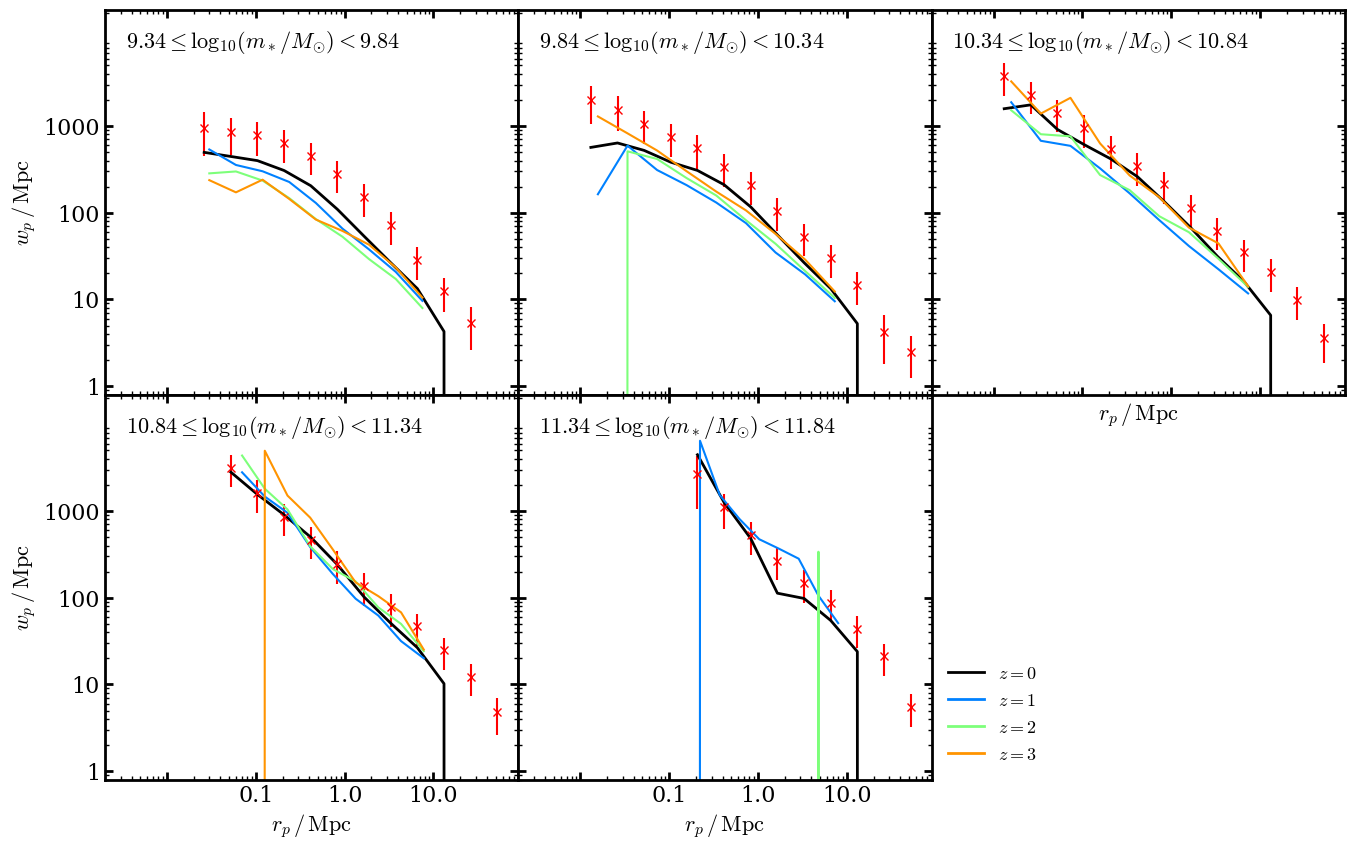

In [100]:
handles = []
ax = plot_stats_clustering(P200.statistics.Clustering, observations=True, color='k', lw=2)
handles += [Line2D([0], [0], color='k', lw=2, ls = '-', label='$z=0$')]

mass_bins = np.array([9.34, 9.84, 10.34, 10.84, 11.34, 11.84])
pi_max = 10/P200.cosmology.h
rp_range = [(0.02, 30),
            (0.01, 60),
            (0.01, 60),
            (0.05, 60),
            (0.1, 60)]
redshifts = [1, 2, 3]
color = [plt.cm.jet((1)/float(4)), plt.cm.jet((2)/float(4)), plt.cm.jet((3)/float(4))]
for j, z in enumerate(redshifts):
    handles += [Line2D([0], [0], color=color[j], lw=2, ls = '-', label='$z={}$'.format(z))]
    for i, axi in enumerate(ax.reshape(-1)[:-1]):
        rmin = np.log10(rp_range[i][0])
        rmax = np.log10(rp_range[i][1])
        rp_bins = np.logspace(rmin,1,10)
        rpc = (rp_bins[:-1]+rp_bins[1:])/2
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        coords = P200.galaxy.list(min_mstar=min_mass, max_mstar=max_mass,z=z)[['X_pos', 'Y_pos', 'Z_pos']].values
        if len(coords) > 0:
            xi = wp(coords, rp_bins, pi_max, period=P200.BoxSize/P200.cosmology.h)
            axi.plot(rpc,xi, color=color[j])

ax[-1,-1].axis('off')
ax[0,2].set_xlabel('$r_p \, / \, \mathrm{Mpc}$', size=16)
ax[0,0].texts[0].remove()
ax[0,0].annotate('$9.34 \leq \log_{10}(m_*/M_{\odot}) < 9.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,1].texts[0].remove()
ax[0,1].annotate('$9.84 \leq \log_{10}(m_*/M_{\odot}) < 10.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,2].texts[0].remove()
ax[0,2].annotate('$10.34 \leq \log_{10}(m_*/M_{\odot}) < 10.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,0].texts[0].remove()
ax[1,0].annotate('$10.84 \leq \log_{10}(m_*/M_{\odot}) < 11.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,1].texts[0].remove()
ax[1,1].annotate('$11.34 \leq \log_{10}(m_*/M_{\odot}) < 11.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')

ax[-1,-1].legend(handles=handles, frameon=False, loc='lower left', prop={'size':13})


plt.show()

# Section 3: FROM SIMULATION TO OBSERVATION

## Section 3.1: Light-cone construction

In [5]:
# Construct datasets
# Really abusing the methods here. there is no guarantee of cone uniqueness with these startup params. so we turn on randomization.
P200.galaxy.survey.new_observation(group='GOODS-S', name='wide', m=8, n=5, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=42)
P200.galaxy.survey.new_observation(group='GOODS-S', name='deep', m=9, n=6, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=42)
P200.galaxy.survey.new_observation(group='GOODS-N', name='wide', m=8, n=5, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=24)
P200.galaxy.survey.new_observation(group='GOODS-N', name='deep', m=9, n=6, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=24)
P200.galaxy.survey.new_observation(group='COSMOS', name='wide', m=10, n=4, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=25)
P200.galaxy.survey.new_observation(group='UDS', name='wide', m=9, n=4, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=26)
P200.galaxy.survey.new_observation(group='EGS', name='wide', m=13, n=3, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=27)
P200.galaxy.survey.new_observation(group='SDSS', name='DR4', m=1.10636, n=1.10636, min_z=0.03, max_z=0.05, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=28)

P200.galaxy.survey.new_observation(group='Full', name='LoS_z', method='full_width', min_z=0, max_z=6, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=29)

P200.galaxy.survey.save()

## Section 3.2: Identifying close pairs

In [12]:
# first bin then setup the distance matrix for each observation
pair_path = os.path.join(P200.out_dir,'lightcone_pairs.h5')
observations = [('GOODS-S', 'wide', 10),
                ('GOODS-N', 'wide', 10),
                ('COSMOS', 'wide', 10),
                ('UDS', 'wide', 10),
                ('EGS', 'wide', 10),
                ('GOODS-S', 'deep', 10),
                ('GOODS-N', 'deep', 10),
                ('SDSS', 'DR4', [0.03, 0.05]),
                ('Full', 'LoS_z', np.arange(0, 6.25, 0.25))] # this last one takes an hour or so.

for i, obs in enumerate(observations):
    group, name, redshift_bins = obs

    observation = P200.galaxy.survey.obs(group=group, name=name)
    observation.set_cone_slice(bins=redshift_bins)
    observation.set_distance_matrix(max_distance=0.1, comoving=False)
    try:
        observation.pairs = pd.read_hdf(pair_path, key=group+'/'+name, data_columns=True)
    except:
        observation.pairs = get_pairs(observation, P200)
        observation.pairs.to_hdf(pair_path, key=group+'/'+name, data_columns=True)

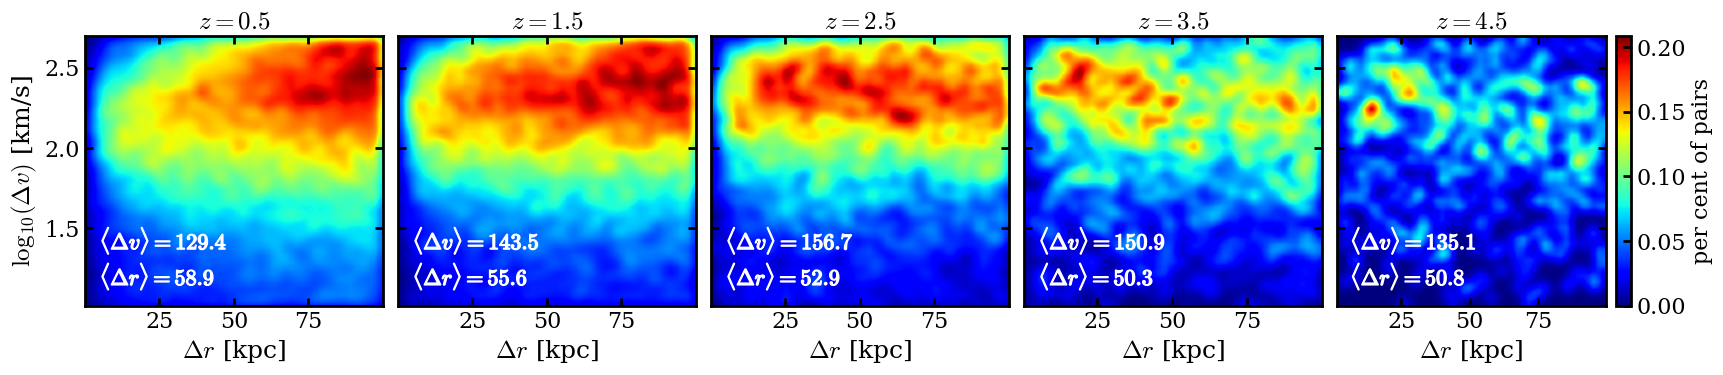

In [13]:
# Distribution of pairs
group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)


z_bins = np.arange(0, 6, 1)
min_mstar = 10.3
max_mstar = np.inf
min_MR = 1
max_MR = 4
min_dr = 0.
max_dr = 0.1
max_dv = 500
min_dv = 10 

fig, ax = plt.subplots(1,len(z_bins)-1,figsize=(20,3.5),sharey=True)

fig.subplots_adjust(wspace=0.05)

ax[0].set_ylabel('$\log_{10}(\Delta v)$ [km/s]',size=18)
for i, axi in enumerate(ax.reshape(-1)):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    #redshift_mask = (main_props['Redshift'].values >= min_z) & (main_props['Redshift'].values < max_z)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask

    
    Y = np.log10(pairs.loc[mask]['dv'].values)
    #Y = pairs.loc[mask]['dv'].values
    X = pairs.loc[mask]['radius'].values*1000

    heatmap, xedges, yedges = np.histogram2d(X, Y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ln = axi.imshow(convolve(100*heatmap.T/heatmap.sum(), Gaussian2DKernel(x_stddev=1)), interpolation='gaussian',extent=extent,aspect='auto',cmap=plt.cm.jet, origin='lower')
    axi.set_title('$z={:.1f}$'.format(np.mean([min_z,max_z])),size=18)
    axi.set_xlabel('$\Delta r$ [kpc]',size=18)
    dv_median = 10**np.median(Y)
    dr_median = np.median(X)
    full_label = '$\\langle \Delta v \\rangle={:.1f}$\n$\\langle \Delta r \\rangle={:.1f}$'.format(dv_median, dr_median)
    txt = axi.annotate(full_label, xy=(0.05, 0.05), xycoords='axes fraction', size=16, ha='left', va='bottom',color='white')

    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w')])

cax = make_square_axes_with_colorbar(axi, size=0.15, pad=0.1)
cbar = fig.colorbar(ln, cax=cax)
cbar.set_label('per cent of pairs',size=16)
#P200.savefig('pair_dist.pdf',bbox_inches='tight')
plt.show()


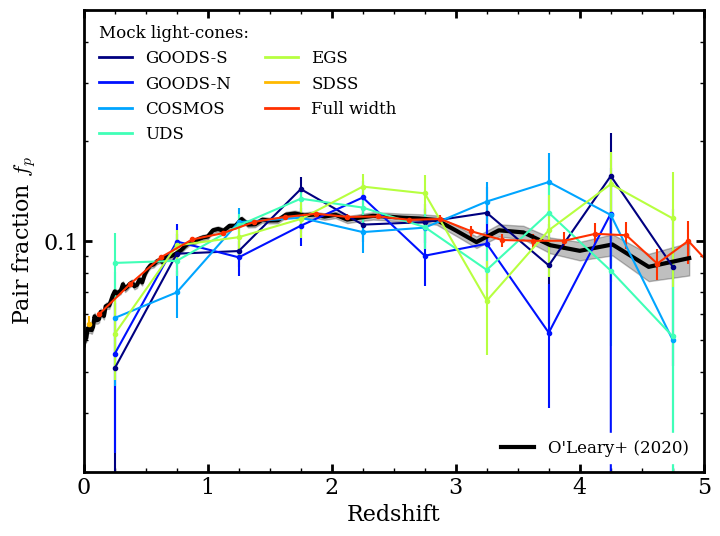

In [16]:
min_mstar, max_mstar = 10.3, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fig, ax = plt.subplots(figsize=(8,6))
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.02, 0.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = [plt.cm.jet(i/(len(observations)-2)) for i in range(len(observations)-2)]

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=3,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')
leg=ax.legend(edgecolor='white', fontsize=12,framealpha=1, loc='lower right', facecolor='white')
ax.add_artist(leg)

Ngc = np.zeros(10)
Npc = np.zeros(10)
c = 0
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    if name == 'deep':
        continue
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    pairs = observation.pairs
    Np = np.zeros(len(pairs.slice.unique()))
    Ng = np.zeros(len(pairs.slice.unique()))
    
    main_props = observation.list(index = pairs['cone_id_main'].values)
    mstar = main_props['Stellar_mass'].values
    mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)
    #redshift = main_props['Redshift'].values
    radius_mask = (pairs['radius'] >= r_min) & (pairs['radius'] < r_max)
    dv_mask = (pairs['dv'] <= dv_max)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    
    galaxies = observation.list(min_mstar=min_mstar, max_mstar=max_mstar)
    gal_mask = (galaxies['Stellar_mass'] >= min_mstar) & (galaxies['Stellar_mass'] < max_mstar)
    
    for j in range(len(Np)):
        zmask = pairs.slice == j
        min_z, max_z = bins[j], bins[j+1]

        Np[j] = (zmask & mstar_mask & dv_mask & radius_mask & MR_mask).sum()
        Ng[j] = ((galaxies['Redshift'] >= min_z) & (galaxies['Redshift'] < max_z) & gal_mask).sum()
    
    if (group is not 'SDSS') and (group is not 'Full'):
        Npc += Np
        Ngc += Ng
    fp = Np/Ng
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[c],label=group+' '+name)
    c+=1
    
    
fp = Npc/Ngc
err = fp/np.sqrt(Npc)
observation = P200.galaxy.survey.obs(group='GOODS-S', name='wide')
bins = observation.redshift_bins
z = (bins[:-1] + bins[1:])/2
#ax.errorbar(z, fp, yerr=err, marker='s', color='magenta',label='combined')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
handles = [Line2D([0], [0], color=color[0], lw=2, ls = '-', label='GOODS-S'),
           Line2D([0], [0], color=color[1], lw=2, ls = '-', label='GOODS-N'),
           Line2D([0], [0], color=color[2], lw=2, ls = '-', label='COSMOS'),
           Line2D([0], [0], color=color[3], lw=2, ls = '-', label='UDS'),
           Line2D([0], [0], color=color[4], lw=2, ls = '-', label='EGS'),
           Line2D([0], [0], color=color[5], lw=2, ls = '-', label='SDSS'),
           Line2D([0], [0], color=color[6], lw=2, ls = '-', label='Full width')]
leg = ax.legend(handles=handles, title = 'Mock light-cones:', frameon=False, ncol=2, loc='upper left',fontsize=12)
leg._legend_box.align = "left"
leg.get_title().set_fontsize('12') 
#P200.savefig('pair_fraction.pdf', bbox_inches='tight')
plt.show()

# Section 4: MERGING PROBABILITIES AND TIMESCALES

## Section 4.2: Merging probability

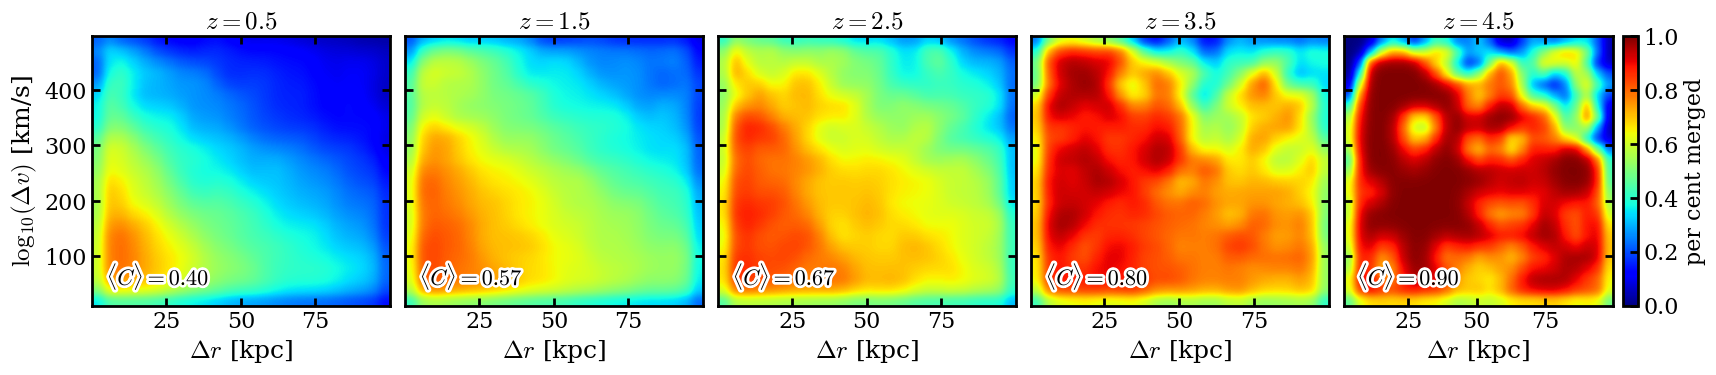

In [17]:
# Merging probability plot 2D

group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)


z_bins = np.arange(0, 6, 1)
min_mstar, max_mstar = 10.3, np.inf
min_MR = 1
max_MR = 4
min_dr = 0.
max_dr = 0.1
max_dv = 500
min_dv = 10 

fig, ax = plt.subplots(1,len(z_bins)-1,figsize=(20,3.5),sharey=True)

fig.subplots_adjust(wspace=0.05)

ax[0].set_ylabel('$\log_{10}(\Delta v)$ [km/s]',size=18)
for i, axi in enumerate(ax.reshape(-1)):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    Y = pairs.loc[mask]['dv'].values
    X = pairs.loc[mask]['radius'].values*1000
    Z = pairs.loc[mask]['merged'].values.astype(int)

    nbin = 25
    heatmap, xedges, yedges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbin)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    ln = axi.imshow(convolve(heatmap.T, Gaussian2DKernel(x_stddev=1)), interpolation='gaussian',extent=extent,aspect='auto',cmap=plt.cm.jet, origin='lower',vmin=0,vmax=1)
    axi.set_title('$z={:.1f}$'.format(np.mean([min_z,max_z])),size=18)
    axi.set_xlabel('$\Delta r$ [kpc]',size=18)
    full_label = '$\\langle C \\rangle={:.2f}$'.format(Z.mean())
    txt = axi.annotate(full_label, xy=(0.05, 0.05), xycoords='axes fraction', size=16, ha='left', va='bottom',color='k')

    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

cax = make_square_axes_with_colorbar(axi, size=0.15, pad=0.1)
cbar = fig.colorbar(ln, cax=cax)
cbar.set_label('per cent merged',size=16)
#P200.savefig('merge_prob.pdf',bbox_inches='tight')
plt.show()


### Model fitting

In [43]:
# Define weighting functions, add more by copying the code below, you can then fit by setting the model key in the cells below.
model_W={}

key = 'A'
def W_A(X, a0, az, ar, b0, bz, c):
    r,v,z = X
    a = a0*((1+z)**az) + r*ar 
    b = b0 + (1+z)*bz
    return np.exp(b*r) / (1+np.exp((v-a)*c))

model_W[key] = Namespace()
model_W[key].p0 = [289.3882, 0.7130, -2.1029, -0.0126, 0.0020, 0.0061]
model_W[key].popt = model_W[key].p0
model_W[key].func = W_A
model_W[key].pstring = ['a_{0}', 'a_{z}', 'a_{r}', 'b_{0}', 'b_{z}', 'c']


In [44]:
# set the data to fit to. we are fitting to the binned data, not the data points directly

group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)

min_mstar, max_mstar  = 10.3, np.inf
min_MR, max_MR = 1, 4
min_dr, max_dr = 0.0, 0.1
min_dv, max_dv = 0, 500

z_bins = np.arange(0., 5, 0.5)

x_fit = []
y_fit = []
z_fit = []
N_fit = []
sig_fit = []
for i in range(len(z_bins)-1):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    
    Y = pairs.loc[mask]['dv'].values
    X = pairs.loc[mask]['radius'].values*1000
    Z = pairs.loc[mask]['merged'].values.astype(int)

    nbins=8
    N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
    sigma, _, _, _ = binned_statistic_2d(X, Y, Z, statistic=np.std, bins=[x_edges, y_edges])
    while np.isnan(N).any() or (N==1).any() or (sigma==0).any():
        nbins -= 1
        N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
        sigma, _, _, _ = binned_statistic_2d(X, Y, Z, statistic=np.std, bins=[x_edges, y_edges])
    #print(nbins, len(N.flatten()), len(sigma.flatten()))

    xb = (x_edges[:-1] + x_edges[1:])/2 # velocity
    yb = (y_edges[:-1] + y_edges[1:])/2 # radius
    x = np.outer(xb, np.ones(len(xb)))
    y = np.outer(yb, np.ones(len(yb))).T
    z = y*0 + np.mean([min_z,max_z])

    x_fit += [x.flatten()]
    y_fit += [y.flatten()]
    z_fit += [z.flatten()]
    N_fit += [N.flatten()]
    sig_fit += [sigma.flatten()]

x_fit = np.concatenate(x_fit, axis=0)
y_fit = np.concatenate(y_fit, axis=0)
z_fit = np.concatenate(z_fit, axis=0)
N_fit = np.concatenate(N_fit, axis=0)
sig_fit = np.concatenate(sig_fit, axis=0)
#popt, pcov = curve_fit(model_W['A'].func, (x_fit, y_fit, z_fit), N_fit, sigma=sig_fit, p0=model_W['A'].p0) # sometimes use this for quick checks.
#display(Math(param_string.format(*popt)))

In [45]:
keys=['A'] # if you have defined more than one function you can add them to this list to compare one another.
keyin=False
for model_key in model_W.keys():
    if keyin:
        if model_key in keys:
            continue
    else:
        if model_key not in keys:
            continue
            
    model = model_W[model_key].func
    p0 = model_W[model_key].p0

    pos = np.array(p0) + 1e-3 * np.random.randn(32, len(p0))
    nwalkers, ndim = pos.shape


    X = (x_fit, y_fit, z_fit, N_fit, sig_fit)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, X, p0))
    sampler.run_mcmc(pos, 50000, progress=True);
    model_W[model_key].sampler = sampler

    discard = np.ceil(np.max(sampler.get_autocorr_time())/100).astype(int)*200
    flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)
    #bf_params = np.zeros((len(p0),3))
    txt = model_key+':\;'
    ltxt=''
    theta = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        s = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}},\;"
        lstr = '& ${0:.4f}^{{+{1:.4f}}}_{{-{2:.4f}}}$ '
        txt += s.format(mcmc[1], q[0], q[1], model_W[model_key].pstring[i])
        ltxt += lstr.format(mcmc[1], q[0], q[1], model_W[model_key].pstring[i])
        theta += [mcmc[1]]
    chi2 = -2*log_likelihood(theta,model,X)
    nu = len(x_fit) - ndim
    txt += "\chi^2 = {:.3f},\;".format(chi2)
    txt += "\chi^2_{{\mathrm{{{1}}}}} = {0:.3f}".format(chi2/nu,'red')
    display(Math(txt))
    model_W[model_key].popt = theta
print(ltxt)

100%|██████████| 50000/50000 [03:22<00:00, 247.35it/s]


<IPython.core.display.Math object>

& $291.9152^{+66.7627}_{-74.7276}$ & $0.7205^{+0.2219}_{-0.2706}$ & $-2.3148^{+2.0262}_{-1.7033}$ & $-0.0121^{+0.0053}_{-0.0061}$ & $0.0019^{+0.0013}_{-0.0012}$ & $0.0058^{+0.0017}_{-0.0027}$ 


In [42]:
keys=['A'] # if you have defined more than one function you can add them to this list to compare one another.
keyin=False
for model_key in model_W.keys():
    if keyin:
        if model_key in keys:
            continue
    else:
        if model_key not in keys:
            continue
            
    model = model_W[model_key].func
    p0 = model_W[model_key].p0

    pos = np.array(p0) + 1e-3 * np.random.randn(32, len(p0))
    nwalkers, ndim = pos.shape


    X = (x_fit, y_fit, z_fit, N_fit, sig_fit)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, X, p0))
    sampler.run_mcmc(pos, 50000, progress=True);
    model_W[model_key].sampler = sampler

    discard = np.ceil(np.max(sampler.get_autocorr_time())/100).astype(int)*200
    flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)
    #bf_params = np.zeros((len(p0),3))
    txt = model_key+':\;'
    theta = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        s = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}},\;"
        txt += s.format(mcmc[1], q[0], q[1], model_W[model_key].pstring[i])
        theta += [mcmc[1]]
    chi2 = -2*log_likelihood(theta,model,X)
    nu = len(x_fit) - ndim
    txt += "\chi^2 = {:.3f},\;".format(chi2)
    txt += "\chi^2_{{\mathrm{{{1}}}}} = {0:.3f}".format(chi2/nu,'red')
    display(Math(txt))
    model_W[model_key].popt = theta

100%|██████████| 50000/50000 [04:26<00:00, 187.63it/s]


<IPython.core.display.Math object>

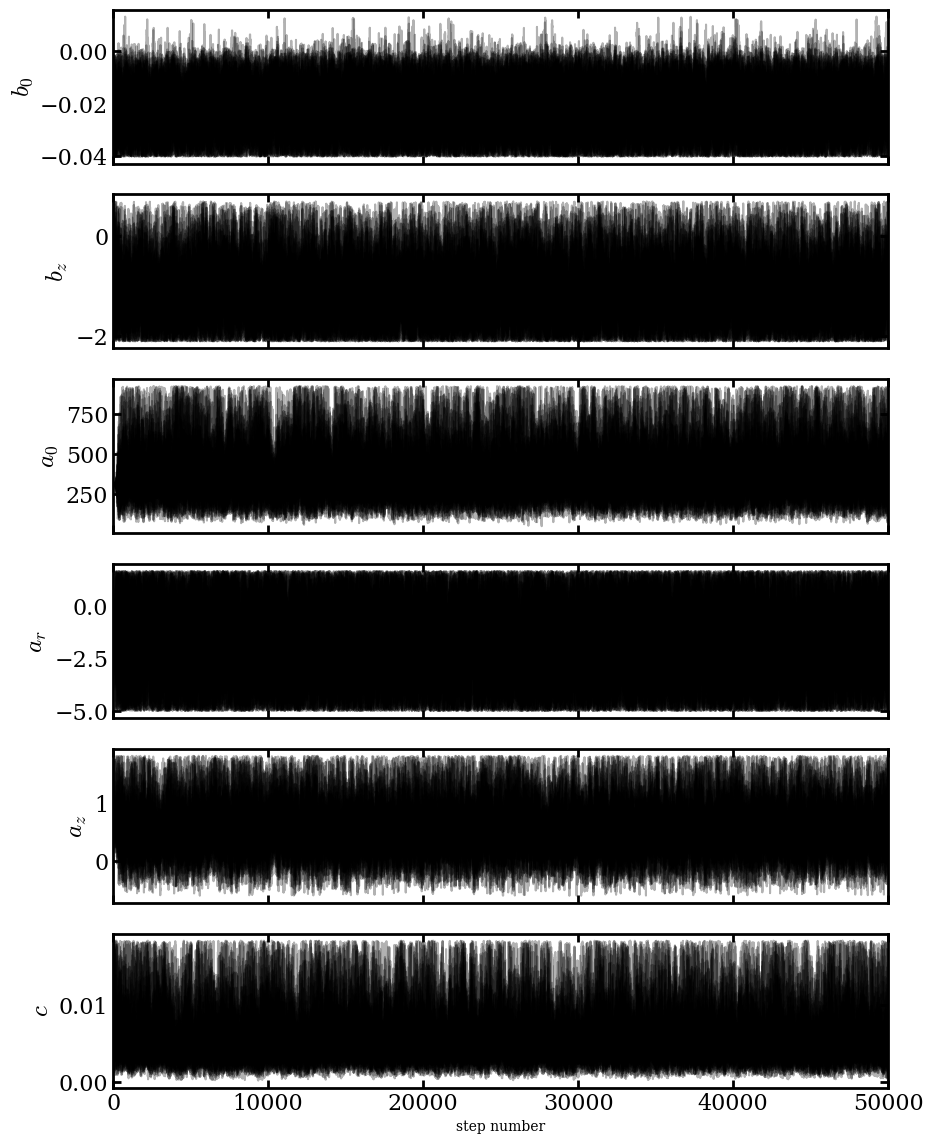

In [138]:
# check the chains
key='A'
fig, axes = plt.subplots(len(p0), figsize=(10, 14), sharex=True)
samples = model_W[key].sampler.get_chain()
#labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel('$'+model_W[key].pstring[i]+'$',size=18)
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

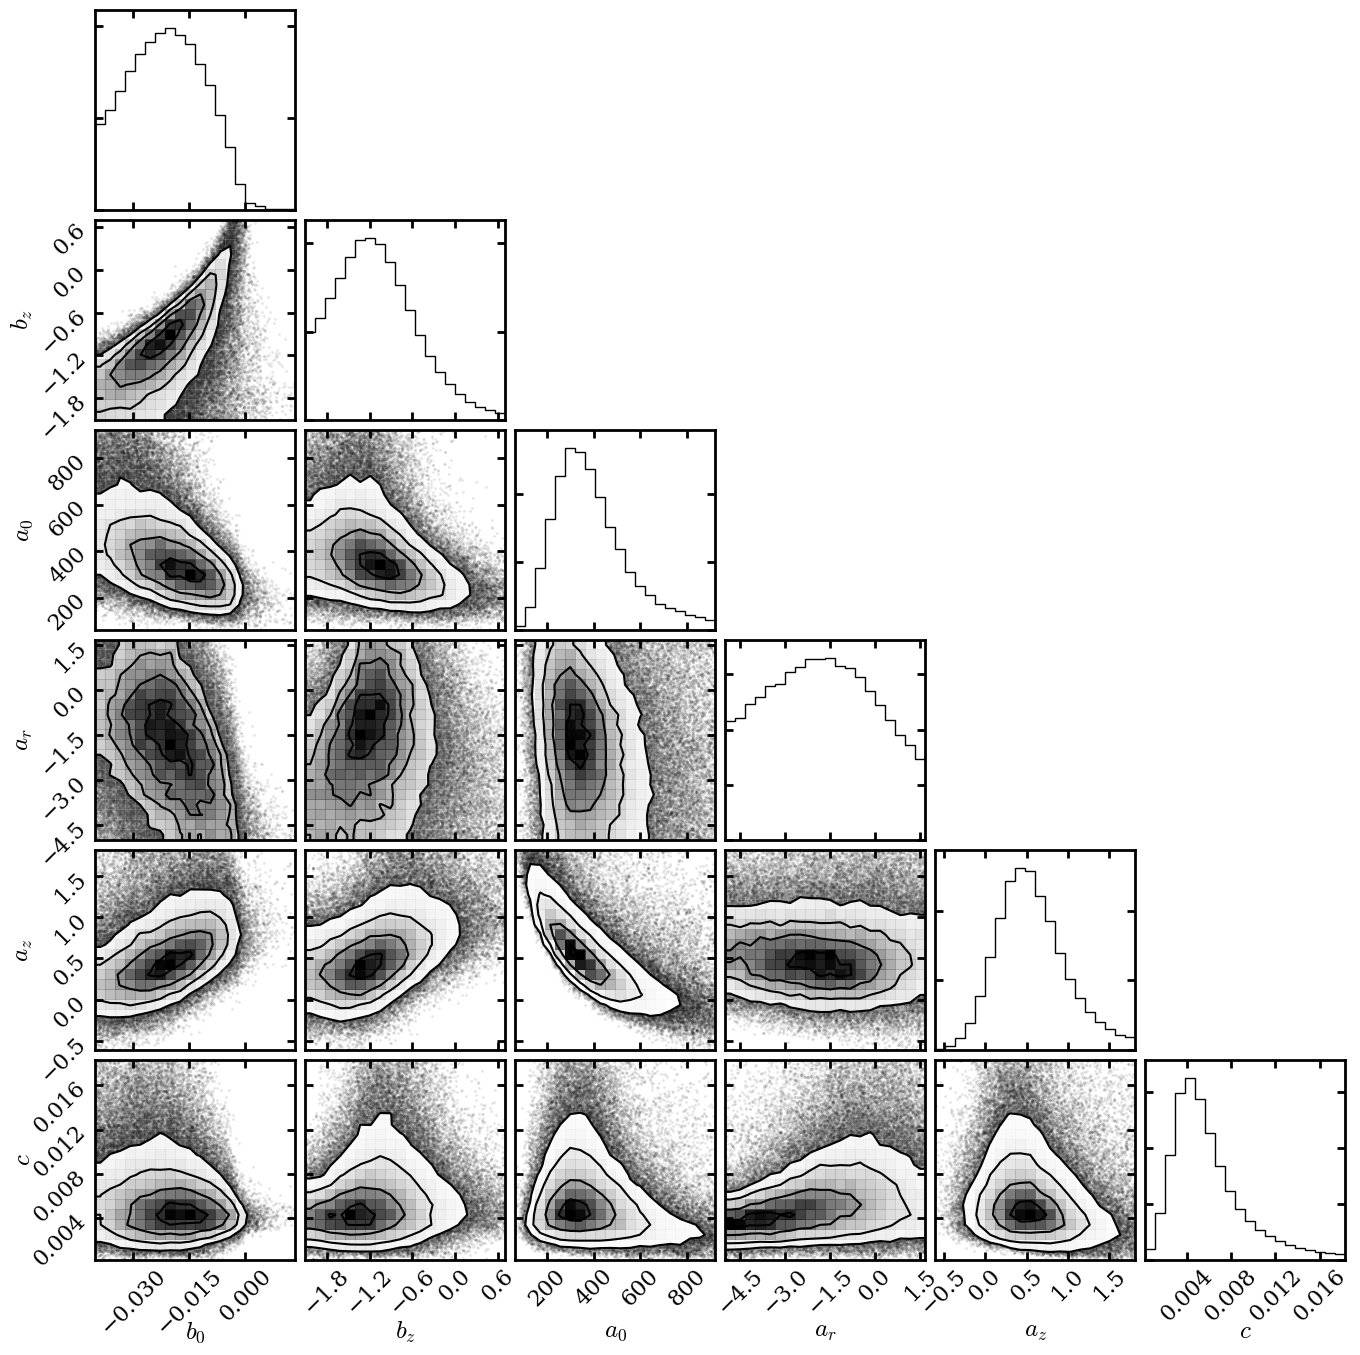

In [139]:
# Parameter covariance plot
model_key = 'A'
discard = np.ceil(np.max(model_W[model_key].sampler.get_autocorr_time())/100).astype(int)*200
flat_samples = model_W[model_key].sampler.get_chain(discard=discard, thin=15, flat=True)
labels = ['$'+ l +'$' for l in model_W[model_key].pstring]
fig = corner.corner(flat_samples,labels=labels, label_kwargs={'size':18})
#P200.savefig('C_cov.pdf',bbox_inches='tight')
plt.show()

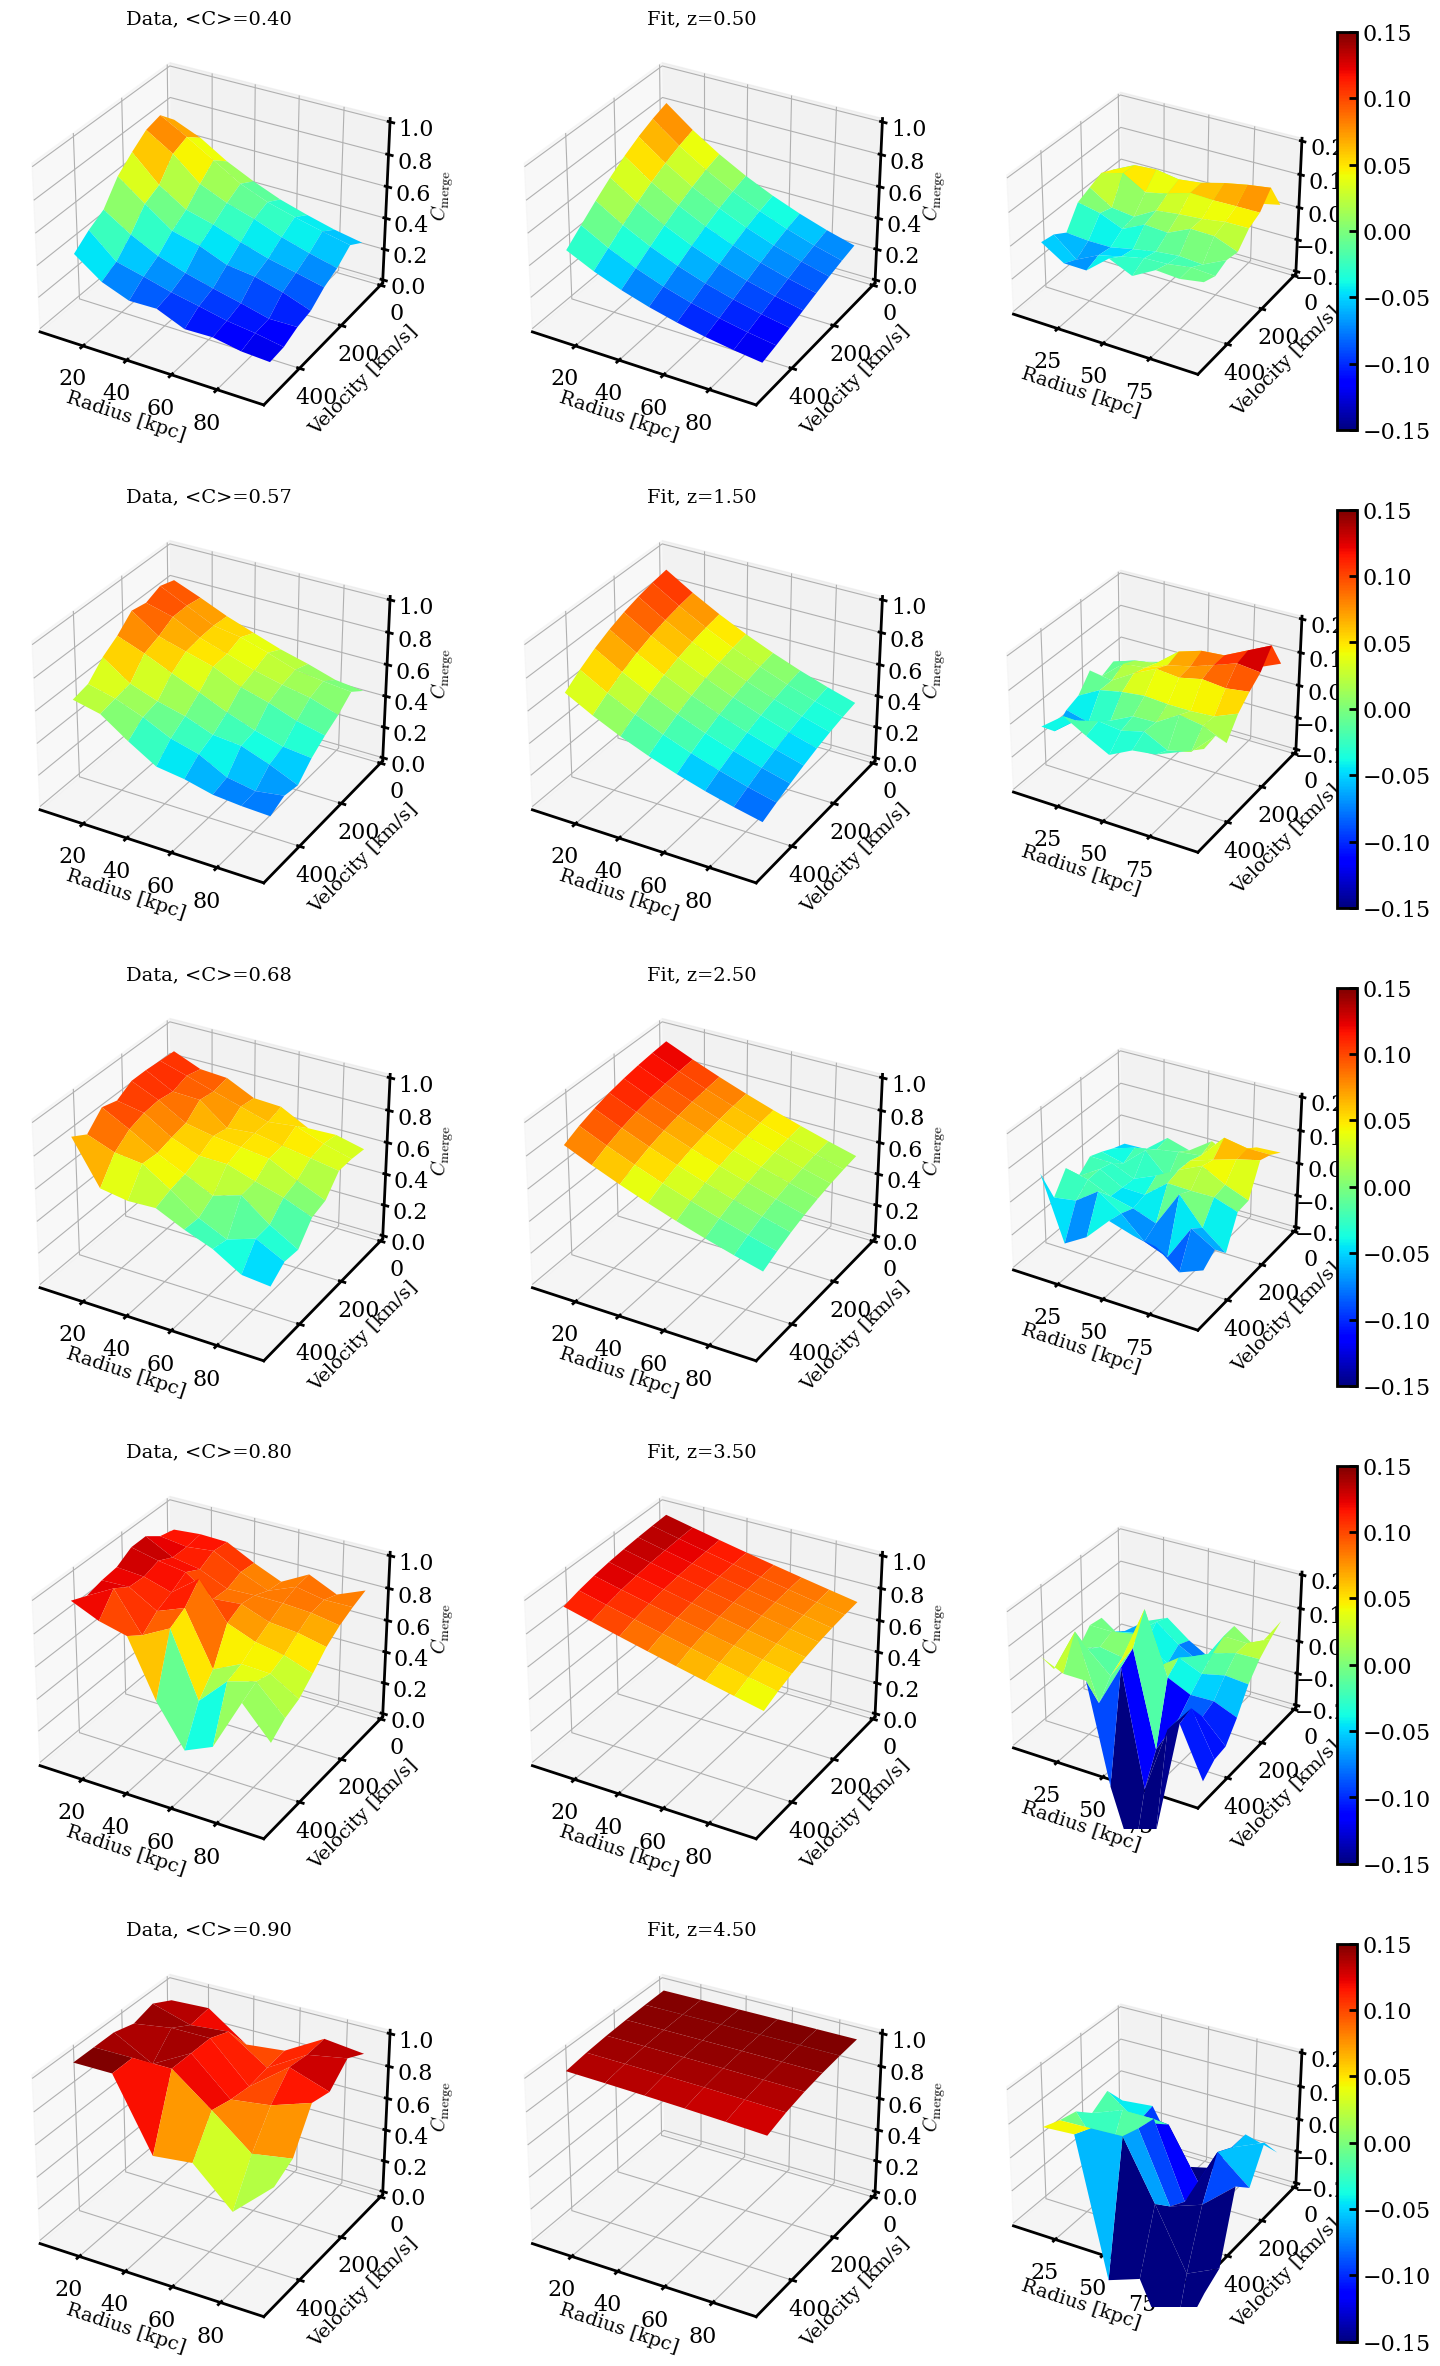

In [22]:
model_key = 'A'
z_bins = np.arange(0, 6., 1)

nrow = len(z_bins)-1
ncol = 3
#popt = mcmc[1]
fig = plt.figure(figsize=(18,6*(len(z_bins)-1)))
c=1
fit = False # if true each redshift bin will be fit individually 
for i in range(len(z_bins)-1):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    
    Y = pairs.loc[mask]['dv'].values
    X = pairs.loc[mask]['radius'].values*1000
    Z = pairs.loc[mask]['merged'].values.astype(int)

    
    nbins=8
    N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
    while np.isnan(N).any():
        nbins -= 1
        N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)

    #fig = plt.figure(figsize=plt.figaspect(0.5))
    #fig = plt.figure(figsize=(18,6))

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_ylim3d(550,0)
    ax.set_zlim3d(0,1)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)
    ax.set_zlabel('$C_{\mathrm{merge}}$',size=14)
    ax.set_title('Data, <C>={:.2f}'.format(Z.mean()),size=14)
    c+=1


    xb = (x_edges[:-1] + x_edges[1:])/2 # velocity
    yb = (y_edges[:-1] + y_edges[1:])/2 # radius
    x = np.outer(xb, np.ones(len(xb)))
    y = np.outer(yb, np.ones(len(yb))).T
    z = y*0 + np.mean([min_z,max_z])

    ax.plot_surface(x, y, N, cmap=plt.cm.jet, vmin=0,vmax=1)

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_zlim3d(0,1)
    ax.set_ylim3d(550,0)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)
    ax.set_zlabel('$C_{\mathrm{merge}}$',size=14)
    ax.set_title('Fit, z={:.2f}'.format(np.mean([min_z,max_z])),size=14)
    c+=1
    
    if fit:
        popt, pcov = curve_fit(model_W[key].func, (x.flatten(), y.flatten(), z.flatten()),N.flatten(), p0=model_W[key].p0)
        print(popt)
        #print('z={:.2f}'.format(np.mean([min_z,max_z])))
        #display(Math((param_string.format(*popt)))

    Np=model_W[key].func((x,y,z),*model_W[key].popt)     
    ax.plot_surface(x, y, Np, cmap=plt.cm.jet, vmin=0,vmax=1)

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_zlim3d(-0.2,0.2)
    ax.set_ylim3d(550,0)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)

    Nr=(N-Np)
    ln = ax.plot_surface(x, y, Nr, cmap=plt.cm.jet, vmin=-0.15,vmax=0.15)
    cbar = plt.colorbar(ln)
    c+=1
#P200.savefig('C_fit.pdf',bbox_inches='tight')
plt.show()

## Section 4.3: Merging timescales

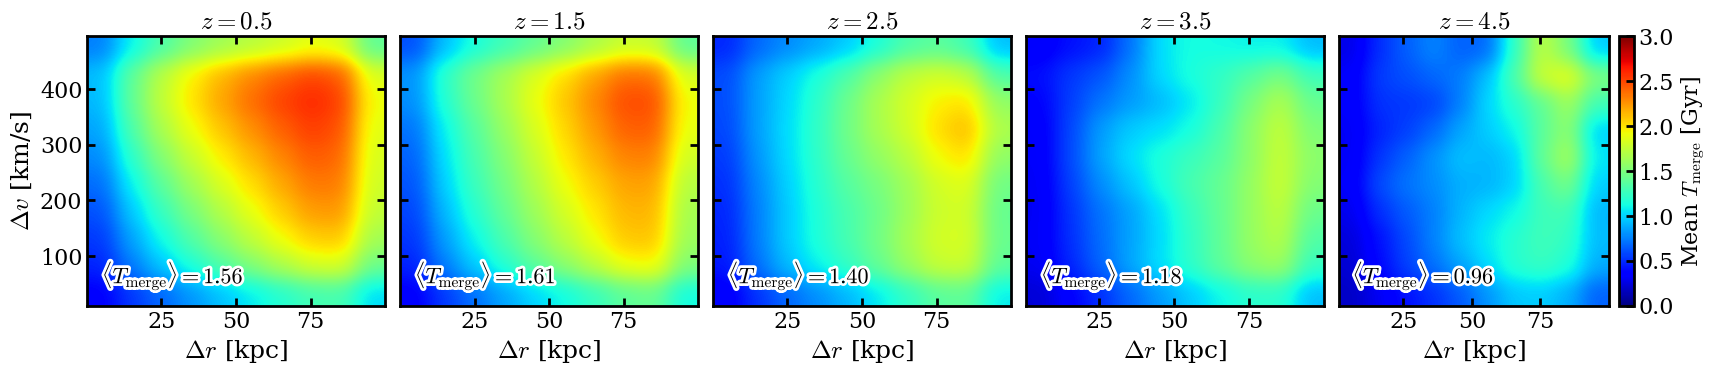

In [129]:
group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)

z_bins = np.arange(0, 6, 1)

min_mstar = 10.3
max_mstar = np.inf
min_MR = 1
max_MR = 4
min_dr = 0.0
max_dr = 0.1
max_dv = 500

fig, ax = plt.subplots(1,len(z_bins)-1,figsize=(20,3.5),sharey=True)
fig.subplots_adjust(wspace=0.05)
ax[0].set_ylabel('$\Delta v$ [km/s]',size=18)
for i, axi in enumerate(ax.reshape(-1)):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    merge_mask = (pairs['merged'].values.astype(int) == 1) 
    
    Y = pairs.loc[mask & merge_mask]['dv'].values
    X = pairs.loc[mask & merge_mask]['radius'].values*1000
    Z = pairs.loc[mask & merge_mask]['tmerge'].astype(float).values
    nbin=10
    heatmap, xedges, yedges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbin)
    #heatmap[np.isnan(heatmap)]=0
    #while (heatmap==0).any():
    #    nbin -= 1
    #    heatmap, xedges, yedges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbin)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #ln=axi.imshow(heatmap.T, interpolation='none',extent=extent,aspect='auto',cmap=plt.cm.jet, origin='lower',vmin=0,vmax=1)
    ln = axi.imshow(convolve(heatmap.T, Gaussian2DKernel(x_stddev=1)), interpolation='gaussian',extent=extent,aspect='auto',cmap=plt.cm.jet, origin='lower',vmin=0,vmax=3)
    axi.set_title('$z={:.1f}$'.format(np.mean([min_z,max_z])),size=18)
    axi.set_xlabel('$\Delta r$ [kpc]',size=18)
    full_label = '$\\langle T_{\mathrm{merge}} \\rangle='+'{:.2f}$'.format(np.mean(Z))
    txt = axi.annotate(full_label, xy=(0.05, 0.05), xycoords='axes fraction', size=16, ha='left', va='bottom',color='k')
    #txt = axi.text(11+MR+0.1,8.25, '$\mu_{M} = '+'{:d}'.format(mr)+'$', horizontalalignment='left', verticalalignment='bottom',fontsize=13)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])


#cbar = plt.colorbar(ln)
cax = make_square_axes_with_colorbar(axi, size=0.15, pad=0.1)
cbar = fig.colorbar(ln, cax=cax)
cbar.set_label('Mean $T_{\mathrm{merge}}$ [Gyr]',size=16)
#P200.savefig('median_T.pdf',bbox_inches='tight')
plt.show()

### Model Fitting

In [32]:
# Define weighting functions, add more by copying the code below, you can then fit by setting the model key in the cells below.

model_T = {}

key = 'A'
def T_A(X,a0,az,b0,bz,c0,cz):
    r,v,z = X
    a = a0 + (1+z)*az
    c = c0 + (1+z)*cz
    b = b0 + (1+z)*bz
    return a + (r*b) + (v*c) 

model_T[key] = Namespace()
model_T[key].name = 'T_'+ '{' + key + '}'
model_T[key].p0 = [-0.2255, 0.1785, 0.0288, -0.0036, 0.0058, -0.0016]
model_T[key].popt = model_T[key].p0
model_T[key].func = T_A
model_T[key].pstring = ['a_{0}','a_{z}', 'b_{0}', 'b_{z}', 'c_{0}', 'c_{z}']

In [46]:
# set the data to fit to. we are fitting to the binned data, not the data points directly
model_key='A'
group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)

min_mstar, max_mstar  = 10.3, np.inf
min_MR, max_MR = 1, 4
min_dr, max_dr = 0.0, 0.1
min_dv, max_dv = 0, 500
prob_thresh = 0.3

z_bins = np.arange(0, 4.5, 0.5)

x_fit = []
y_fit = []
z_fit = []
N_fit = []
sig_fit = []

mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
merge_mask = (pairs['merged'].values.astype(int) == 1) 

for i in range(len(z_bins)-1):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    
    Y = pairs.loc[mask & merge_mask]['dv'].values
    X = pairs.loc[mask & merge_mask]['radius'].values*1000
    Z = pairs.loc[mask & merge_mask]['tmerge'].values.astype(float)

    nbins=8
    N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
    sigma, _, _, _ = binned_statistic_2d(X, Y, Z, statistic=np.std, bins=[x_edges, y_edges]) 
    while np.isnan(N).any() or (N==1).any() or (sigma==0).any():
        nbins -= 1
        N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
        sigma, _, _, _ = binned_statistic_2d(X, Y, Z, statistic=np.std, bins=[x_edges, y_edges]) 
    
    # include merging timescales for grid cells with sufficient merging probability.
    Y = pairs.loc[mask]['dv'].values
    X = pairs.loc[mask]['radius'].values*1000
    Z = pairs.loc[mask]['merged'].values.astype(int)
    prob, _, _, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=[x_edges, y_edges])
    prob_mask = (prob >= prob_thresh)
    
    sigma = sigma[prob_mask].flatten()
    Z = pairs.loc[mask & merge_mask]['tmerge'].values.astype(float)

    xb = (x_edges[:-1] + x_edges[1:])/2 # velocity
    yb = (y_edges[:-1] + y_edges[1:])/2 # radius
    x = np.outer(xb, np.ones(len(xb)))
    y = np.outer(yb, np.ones(len(yb))).T
    z = y*0 + np.mean([min_z,max_z])

    x_fit += [x[prob_mask].flatten()]
    y_fit += [y[prob_mask].flatten()]
    z_fit += [z[prob_mask].flatten()]
    N_fit += [N[prob_mask].flatten()]
    sig_fit += [sigma]

x_fit = np.concatenate(x_fit, axis=0)
y_fit = np.concatenate(y_fit, axis=0)
z_fit = np.concatenate(z_fit, axis=0)
N_fit = np.concatenate(N_fit, axis=0)
sig_fit = np.concatenate(sig_fit, axis=0)
popt, pcov = curve_fit(model_T[model_key].func, (x_fit, y_fit, z_fit), N_fit, sigma=sig_fit, p0=model_T[model_key].p0) # this puts us in a better ballpark before MCMC
model_T[model_key].popt = popt
model_T[model_key].p0 = popt # sometimes use this for quick checks.

txt = model_T[model_key].name+':\;'

for i, p in enumerate(popt):
    s = "\mathrm{{{1}}} = {0:.4f},\;"
    txt += s.format(p, model_T[model_key].pstring[i])

display(Math(txt))

<IPython.core.display.Math object>

In [33]:
keys = ['A']# if you have defined more than one function you can add them to this list to compare one another.
keyin=False
for model_key in model_T.keys():
    if keyin:
        if model_key in keys:
            continue
    else:
        if model_key not in keys:
            continue
            
    model = model_T[model_key].func
    p0 = model_T[model_key].p0

    pos = np.array(p0) + 1e-3 * np.random.randn(32, len(p0))
    nwalkers, ndim = pos.shape


    X = (x_fit, y_fit, z_fit, N_fit, sig_fit)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(model, X, p0))
    sampler.run_mcmc(pos, 50000, progress=True);
    model_T[model_key].sampler = sampler

    discard = np.ceil(np.max(sampler.get_autocorr_time())/100).astype(int)*200
    flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)
    #bf_params = np.zeros((len(p0),3))
    txt = model_key+':\;'
    theta = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        s = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}},\;"
        txt += s.format(mcmc[1], q[0], q[1], model_T[model_key].pstring[i])
        theta += [mcmc[1]]
    chi2 = -2*log_likelihood(theta,model,X)
    nu = len(x_fit) - ndim
    txt += "\chi^2 = {:.3f},\;".format(chi2)
    txt += "\chi^2_{{\mathrm{{{1}}}}} = {0:.3f}".format(chi2/nu,'red')
    display(Math(txt))
    model_T[model_key].popt = theta

100%|██████████| 50000/50000 [01:51<00:00, 447.20it/s]


<IPython.core.display.Math object>

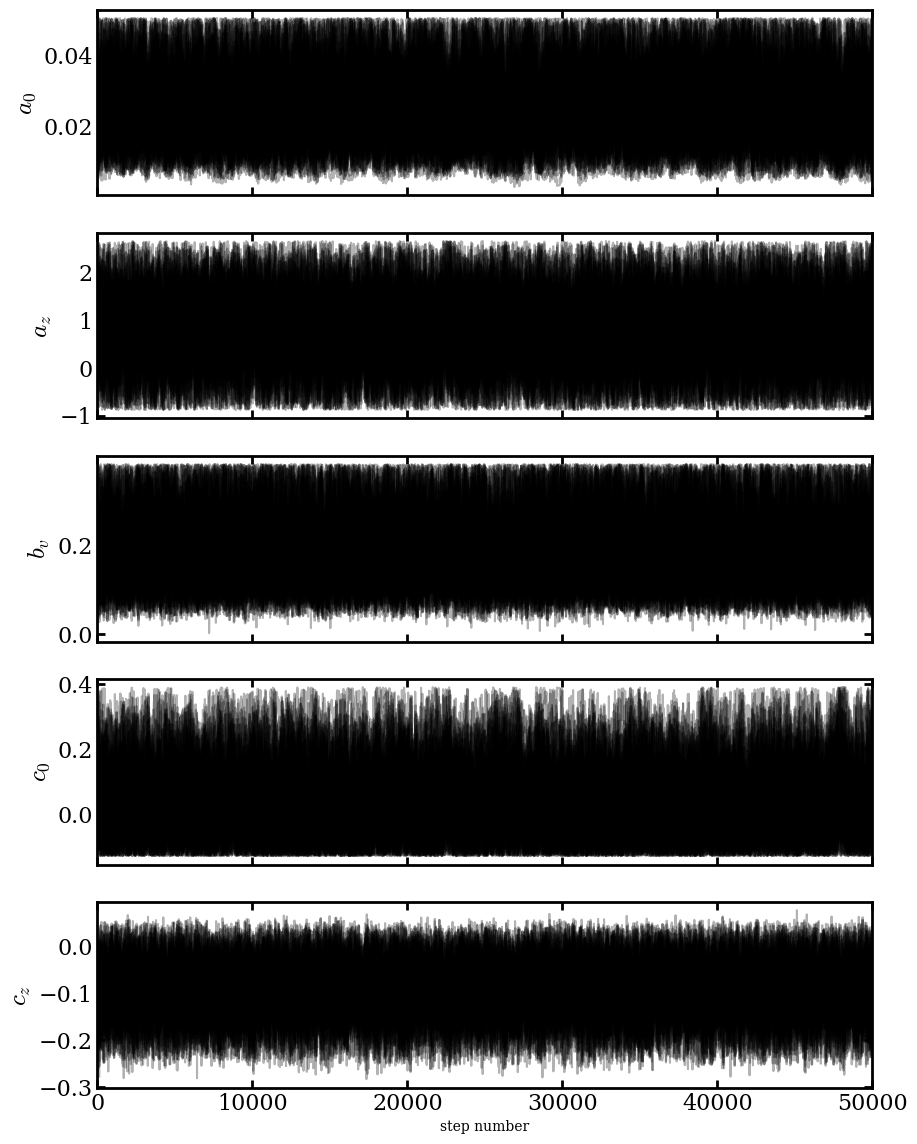

In [157]:
# check the chains
key='A'
fig, axes = plt.subplots(len(p0), figsize=(10, 14), sharex=True)
samples = model_T[key].sampler.get_chain()
#labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel('$'+model_T[key].pstring[i]+'$',size=18)
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

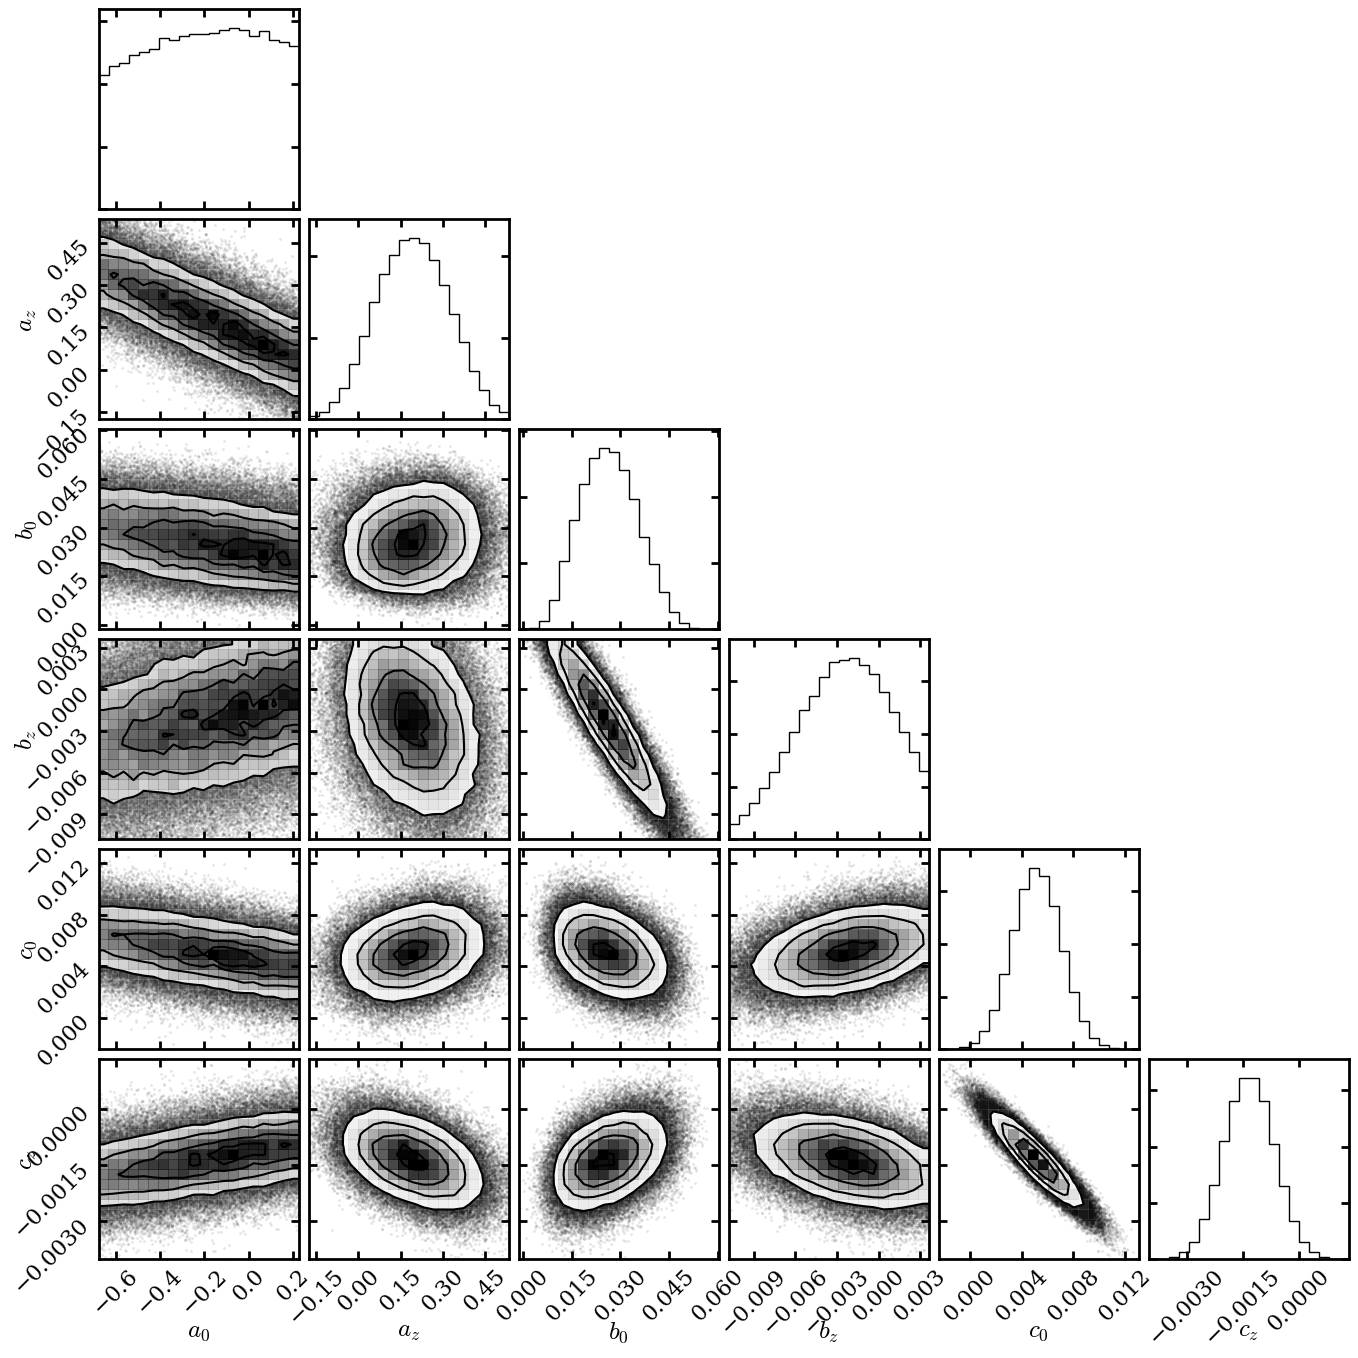

In [34]:
# Parameter covariance plot
model_key = 'A'
discard = np.ceil(np.max(model_T[model_key].sampler.get_autocorr_time())/100).astype(int)*200
flat_samples = model_T[model_key].sampler.get_chain(discard=discard, thin=15, flat=True)
labels = ['$'+ l +'$' for l in model_T[model_key].pstring]
fig = corner.corner(flat_samples,labels=labels, label_kwargs={'size':18})
#P200.savefig('C_cov.pdf',bbox_inches='tight')
plt.show()

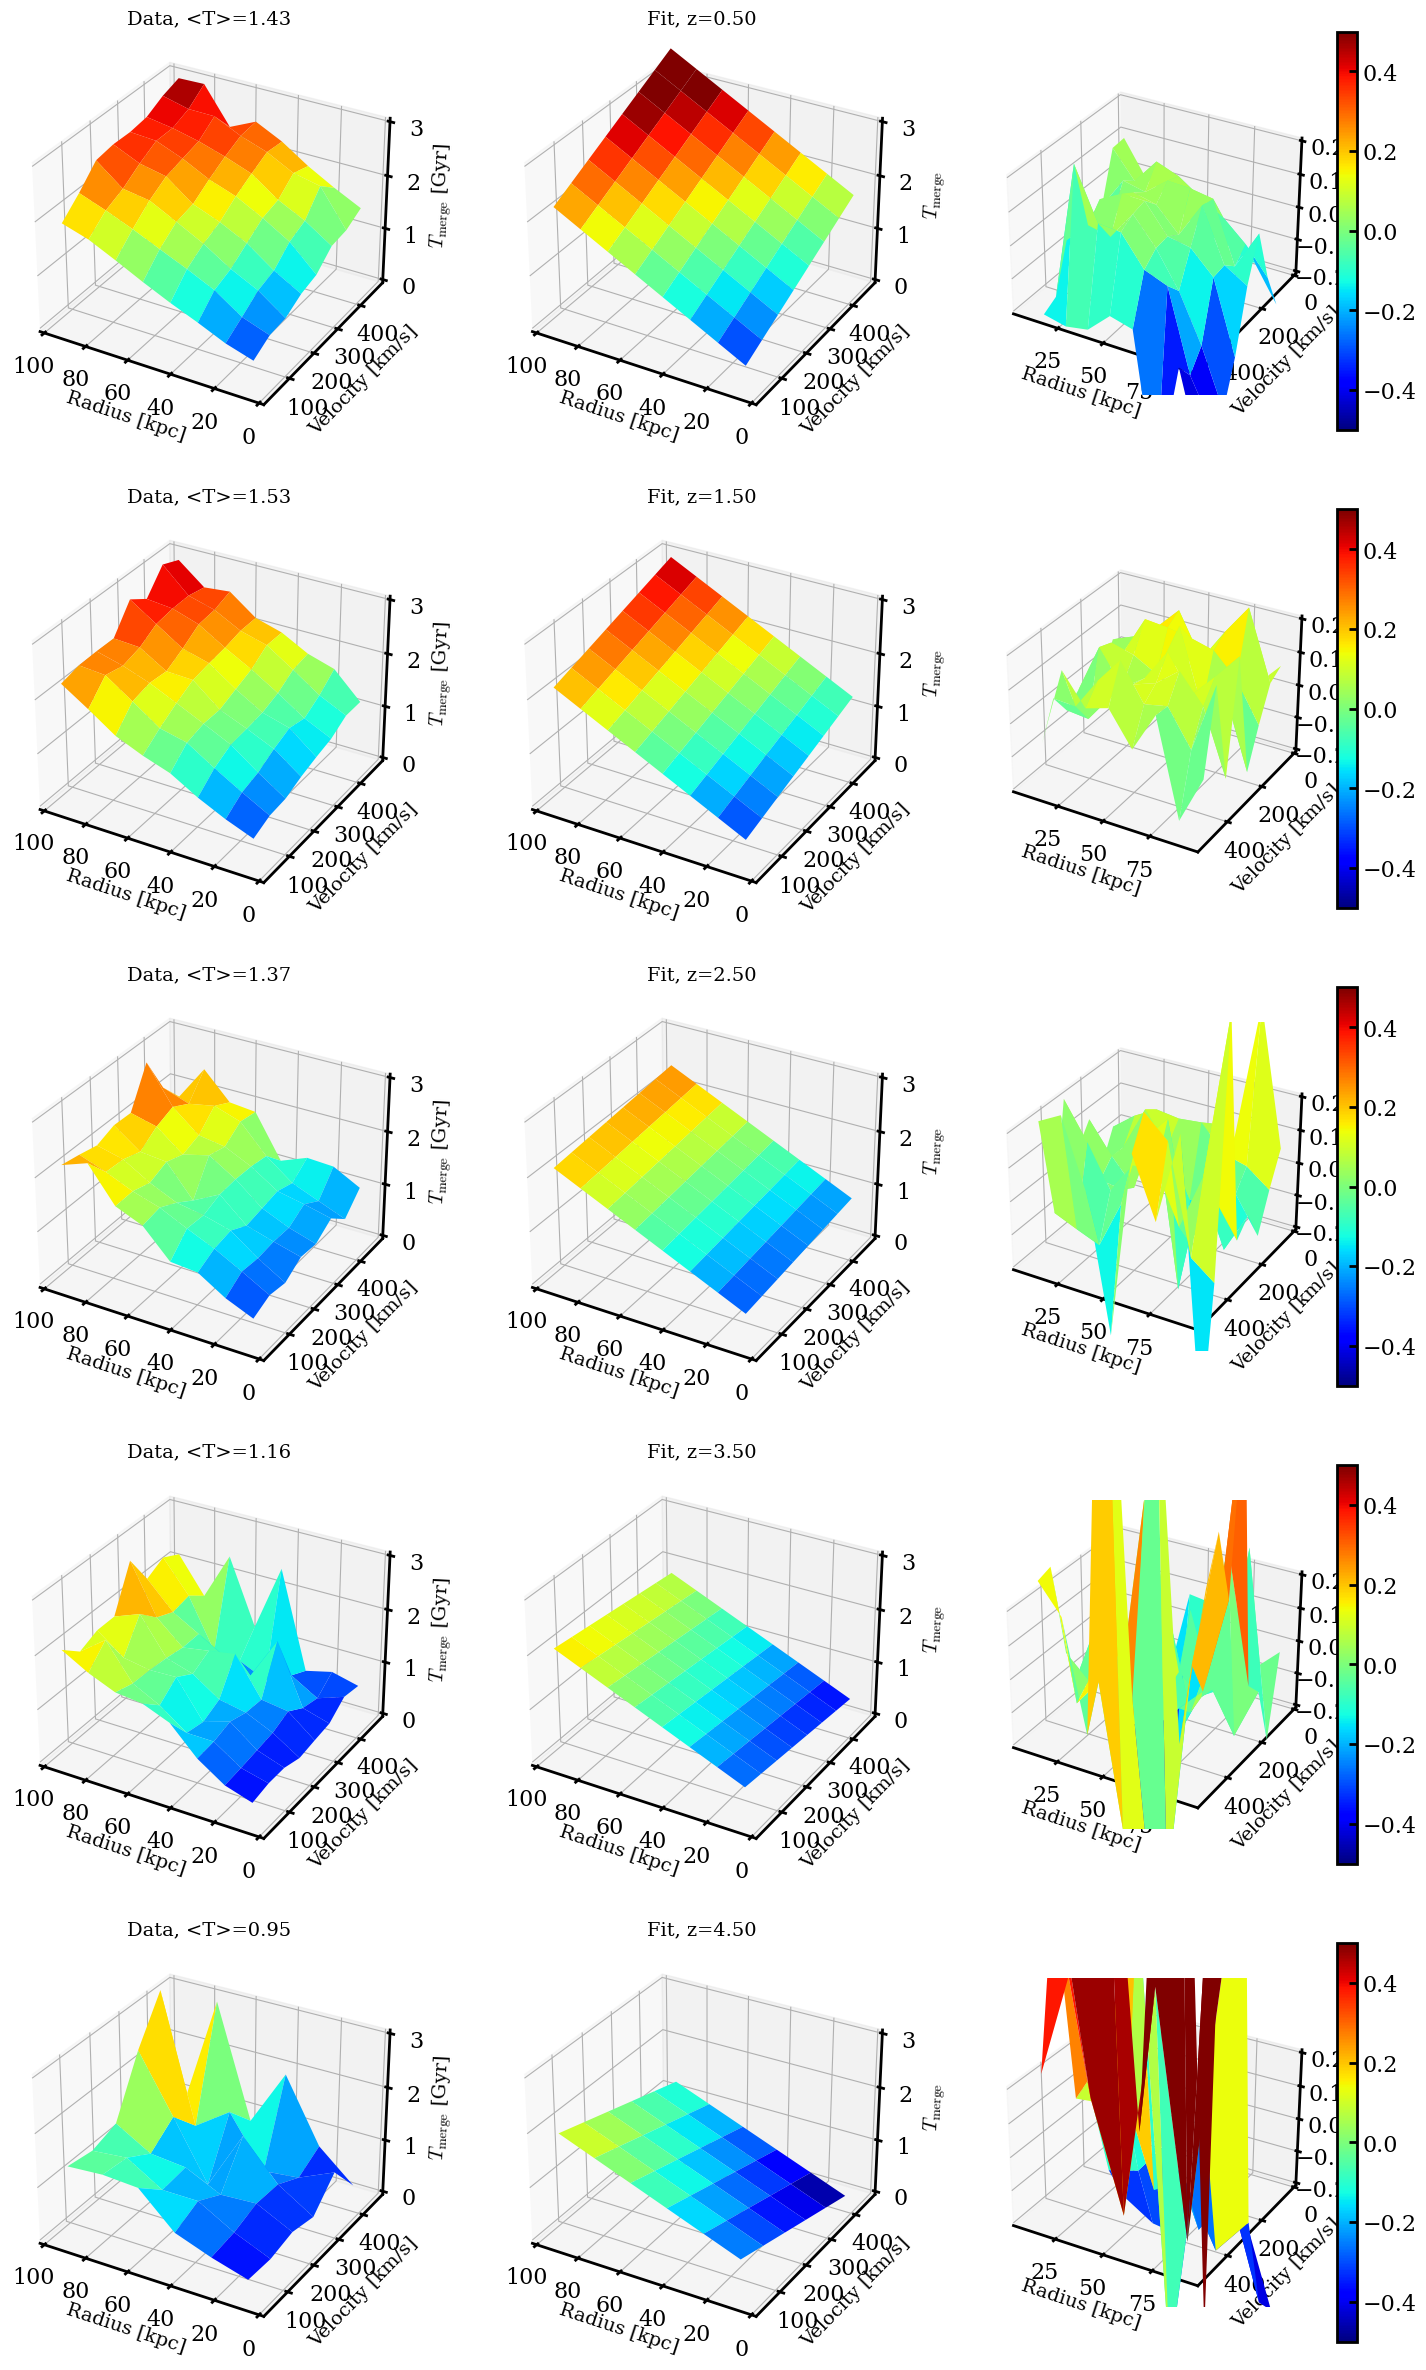

In [28]:
model_key = 'A'
z_bins = np.arange(0, 6., 1)

nrow = len(z_bins)-1
ncol = 3
#popt = mcmc[1]
fig = plt.figure(figsize=(18,6*(len(z_bins)-1)))
c=1
fit = False # if true each redshift bin will be fit individually 

mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
merge_mask = (pairs['merged'].values.astype(int) == 1) 

for i in range(len(z_bins)-1):
    min_z = z_bins[i]
    max_z = z_bins[i+1]
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask
    
    Y = pairs.loc[mask & merge_mask]['dv'].values
    X = pairs.loc[mask & merge_mask]['radius'].values*1000
    Z = pairs.loc[mask & merge_mask]['tmerge'].values.astype(float)

    
    nbins=8
    N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)
    while np.isnan(N).any():
        nbins -= 1
        N, x_edges, y_edges, _ = binned_statistic_2d(X, Y, Z, statistic='mean', bins=nbins)

    #fig = plt.figure(figsize=plt.figaspect(0.5))
    #fig = plt.figure(figsize=(18,6))

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_xlim3d(100,0)
    ax.set_zlim3d(0,3)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)
    ax.set_zlabel('$T_{\mathrm{merge}}$ [Gyr]',size=14)
    ax.set_title('Data, <T>={:.2f}'.format(Z.mean()),size=14)
    c+=1


    xb = (x_edges[:-1] + x_edges[1:])/2 # velocity
    yb = (y_edges[:-1] + y_edges[1:])/2 # radius
    x = np.outer(xb, np.ones(len(xb)))
    y = np.outer(yb, np.ones(len(yb))).T
    z = y*0 + np.mean([min_z,max_z])

    ax.plot_surface(x, y, N, cmap=plt.cm.jet, vmin=0,vmax=3)

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_xlim3d(100,0)
    ax.set_zlim3d(0,3)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)
    ax.set_zlabel('$T_{\mathrm{merge}}$',size=14)
    ax.set_title('Fit, z={:.2f}'.format(np.mean([min_z,max_z])),size=14)
    c+=1
    
    if fit:
        popt, pcov = curve_fit(model_T[key].func, (x.flatten(), y.flatten(), z.flatten()),N.flatten(), p0=model_W[key].p0)
        print(popt)
        #print('z={:.2f}'.format(np.mean([min_z,max_z])))
        #display(Math((param_string.format(*popt)))

    Np=model_T[model_key].func((x,y,z),*model_T[model_key].popt)     
    ax.plot_surface(x, y, Np, cmap=plt.cm.jet, vmin=0,vmax=3)

    ax = fig.add_subplot(nrow,ncol,c, projection='3d')
    ax.set_zlim3d(-0.2,0.2)
    ax.set_ylim3d(550,0)
    ax.set_xlabel('Radius [kpc]',size=14)
    ax.set_ylabel('Velocity [km/s]',size=14)

    Nr=(N-Np)
    ln = ax.plot_surface(x, y, Nr, cmap=plt.cm.jet, vmin=-0.5,vmax=0.5)
    cbar = plt.colorbar(ln)
    c+=1
#P200.savefig('T_fit.pdf',bbox_inches='tight')
plt.show()

# Section 5: RECONSTRUCTING MERGER RATES

In [29]:
def get_tobs(r0, ri, tm, mode=0):
    if mode==0:
        return tm * (1-(ri/r0)**2)
    else:
        return tm * (1-ri/r0)

## Check against full width

Making bins evenly spaced in time


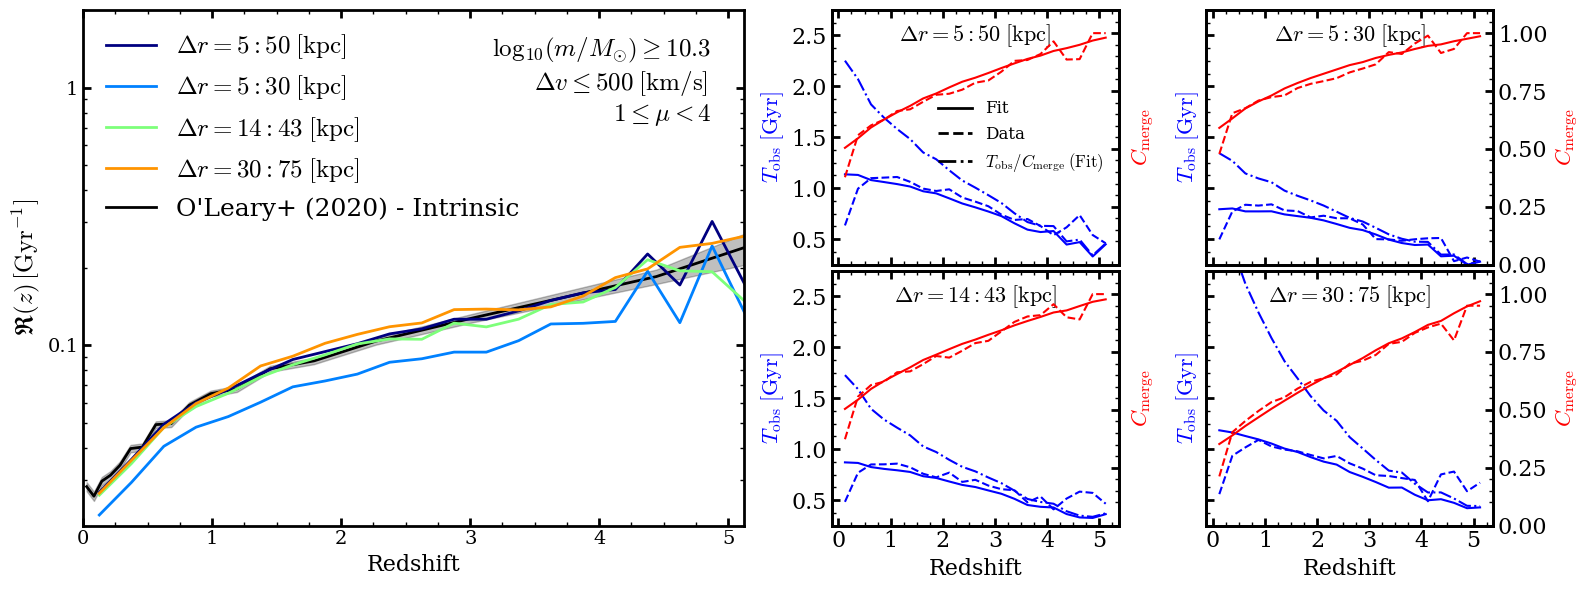

In [36]:
# This cell will just check against the full width dataset.
group, name, redshift_bins = observations[-1]
observation = P200.galaxy.survey.obs(group=group, name=name)
pairs = observation.pairs
main_props = observation.list(index = pairs['cone_id_main'].values)
galaxies = observation.list()[['Redshift_obs', 'Stellar_mass']]

def line(x,m,b):
    return m*x + b

W_key = 'A'
T_key = 'A'
W = model_W[W_key].func
W_popt = model_W[W_key].popt
W_popt = [289.3882, 0.7130, -2.1029, -0.0126, 0.0020, 0.0061] # fits from the paper
T = model_T[T_key].func
T_popt = model_T[T_key].popt
T_popt = [-0.2255, 0.1785, 0.0288, -0.0036, 0.0058, -0.0016] # fits from the paper

z_bins = np.arange(0, 5.5, 0.25)
z = (z_bins[:-1] + z_bins[1:])/2

min_mstar, max_mstar = 10.3, np.inf
min_dr, max_dr = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fp = []
R = []
N = []

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,6), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.5,wspace=0.025)
gs = ax[0, 0].get_gridspec()

# remove the underlying axes
for axi in ax[:2, :2].reshape(-1):
    axi.remove()

axbig = fig.add_subplot(gs[:2, :2])
fig.subplots_adjust(hspace=0.025,wspace=0.025)
axbig.set_xlim(0,5.125)
axbig.set_ylim(0.01,1.6)
axbig.set_ylabel('$\mathfrak{R}(z) \, [\mathrm{Gyr}^{-1}]$', size=18)
axbig.set_xlabel('Redshift',size=16)
axbig.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True, labelsize=14)
axbig.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))
axbig.set_yscale('log')
axbig.set_ylim([2e-2, 2])
axbig.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
tsfr = (10**(max_mstar) - 10**(min_mstar))/(main_props['SFR'].values*(1e9))

dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
merge_mask = (pairs['merged'].values.astype(int) == 1) 

radius_range = [(0.005, 0.05),
                (0.005, 0.03),
                (0.014, 0.043),
                (0.03, 0.075)]
for j, axi in enumerate(ax[0:, 2:].reshape(-1)):
    #for j, rad in enumerate(radius_range):
    min_dr, max_dr = radius_range[j]
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    fp = []
    R = []
    N = []
    T_mod = []
    C_mod = []
    C_dat = []
    T_dat = []
    for i in range(len(z_bins)-1):
        min_z = z_bins[i]
        max_z = z_bins[i+1]

        redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)

        mask = mstar_mask & redshift_mask & radius_mask & dv_mask & MR_mask

        Y = pairs.loc[mask & merge_mask]['dv'].values
        X = pairs.loc[mask & merge_mask]['radius'].values*1000
        Z = pairs.loc[mask & merge_mask]['redshift'].values
        Tmerge = pairs.loc[mask & merge_mask]['tmerge'].values


        To = get_tobs(X,np.full(len(Y), min_dr*1000),Tmerge)
        T_dat += [np.mean(To)]

        Y = pairs.loc[mask]['dv'].values
        X = pairs.loc[mask]['radius'].values*1000
        Z = pairs.loc[mask]['redshift'].values
        C_dat += [np.mean(pairs.loc[mask]['merged'].values)]
        var = list(zip(X,Y,Z))
        Cmerge = np.array([W(v, *W_popt) for v in var])
        Tmerge = np.array([T(v, *T_popt) for v in var])

        Tobs = get_tobs(X,np.full(len(Y), min_dr*1000),Tmerge)
        tsfr_mask = tsfr[mask] < Tobs
        #Tobs = tsfr[mask]

        mask = Tmerge < np.inf
        Tmerge = Tmerge[mask]
        Cmerge = Cmerge[mask]
        Tobs = Tobs[mask]
        T_mod += [np.mean(Tobs)]
        C_mod += [np.mean(Cmerge)]
        #Tobs=Tmerge

        N_pair = len(Y)
        N_gal = ((galaxies['Stellar_mass'] >= min_mstar) & (galaxies['Stellar_mass'] < max_mstar) & (galaxies['Redshift_obs'] >= min_z) & (galaxies['Redshift_obs'] < max_z)).sum()
        fp += [N_pair/N_gal]
        #print(Cmerge.mean(), Tobs.mean())
        C1 = (max_dr**2) / (max_dr**2 - min_dr**2)
        #C1 = 1
        N += [N_pair]
        R += [C1 * N_pair * Cmerge.sum() / Tobs.sum() / N_gal]
    label = '$\Delta r = {{{:d}}}:{{{:d}}}\;[\mathrm{{kpc}}]$'.format(int(min_dr*1000), int(max_dr*1000))
    axbig.plot(z, R, '-',color=plt.cm.jet(j/len(radius_range)), lw=2, label=label)
    txt = axi.annotate(label, xy=(0.5, 1-0.05), xycoords='axes fraction', size=16, ha='center', va='top',color='black')
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))
    axi.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 6, 1)))
    axi.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,3,0.125)))
    axi.set_ylim(0.25,2.75)
    axi.plot(z,T_mod, 'b-')
    axi.plot(z,T_dat, 'b--')
    axi.plot(z, np.array(T_mod)/np.array(C_mod), color = 'b', ls=ls('-.'))
    ax2 = axi.twinx()
    ax2.set_ylim(0,1.1)
    ax2.tick_params('y', direction='in', which = 'both')
    ax2.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.1,1.5,0.05)))
    ax2.plot(z,C_mod, 'r-')
    ax2.plot(z,C_dat, 'r--')
    axi.set_ylabel('$T_{\mathrm{obs}}\; [\mathrm{Gyr}]$',size=16,color='b')
    if j%2 == 0:
        ax2.tick_params(axis='y', labelright=False)
        axi.tick_params(axis='y',labelleft=True)
       # axi.set_ylabel('$T_{\mathrm{obs}}\; [\mathrm{Gyr}]$',size=16,color='b')
    #else:
    ax2.set_ylabel('$C_{\mathrm{merge}}$', color='r',size=16)
        

#yu = R*(1 + 1/np.sqrt(N))
#yd = R*(1 - 1/np.sqrt(N))
#axbig.fill_between(z,yu,yd,alpha=0.25, color='k')


# Plot intrinsic rates
scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 0.75, db_type='time')
N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_main_mstar=min_mstar, max_main_mstar=max_mstar, min_MR=min_MR, max_MR=max_MR)
z = (redshift[1:] + redshift[:-1])/2
dt = np.diff(time)
norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mstar=min_mstar, max_mstar=max_mstar)
clean = (N_merge > 0) & (norm_gal<np.inf)
y = norm_gal[clean]*N_merge[clean]/dt[clean]
yu = norm_gal[clean]*(N_merge[clean]+N_merge[clean]/np.sqrt(N_merge[clean]))/dt[clean]
yd = norm_gal[clean]*(N_merge[clean]-N_merge[clean]/np.sqrt(N_merge[clean]))/dt[clean]
axbig.fill_between(z[clean],yu,yd,alpha=0.25, color='k')




axbig.plot(z,norm_gal*N_merge/dt,'k-', lw=2, label='O\'Leary+ (2020) - Intrinsic',zorder=0)
axbig.legend(frameon=False, fontsize=18, loc='upper left')
ax[1,-1].set_xlabel('Redshift',size=16)
ax[1,-2].set_xlabel('Redshift',size=16)

handles = [Line2D([0], [0], color='k', lw=2, ls = ls('-'),label='Fit'),
           Line2D([0], [0], color='k', lw=2, ls = ls('--'),label='Data'),
           Line2D([0], [0], color='k', lw=2, ls = ls('-.'),label='$T_{\mathrm{obs}}/C_{\mathrm{merge}}\; \mathrm{(Fit)}$')]
ax[0,2].legend(handles=handles, frameon=False, loc = 'center right',fontsize=12)

label = '$\log_{10}(m/M_{\odot}) \geq 10.3$\n$\Delta v \leq 500\; [\mathrm{km/s}]$ \n $1 \leq \mu < 4$'
txt = axbig.annotate(label, xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=18, ha='right', va='top',color='black')

fig.tight_layout()
fig.subplots_adjust(hspace=0.025)
#P200.savefig('validation.pdf', bbox_inches='tight')

plt.show()

## Run on all cones

Making bins evenly spaced in time


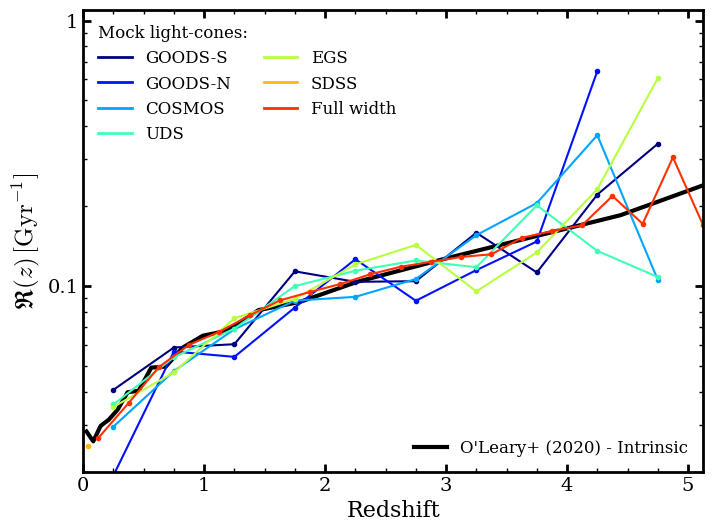

In [37]:
min_mstar, max_mstar = 10.3, np.inf
min_dr, max_dr = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500


fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlim(0,5.125)
ax.set_ylim(0.01,1.6)
ax.set_ylabel('$\mathfrak{R}(z) \, [\mathrm{Gyr}^{-1}]$', size=18)
ax.set_xlabel('Redshift',size=16)
ax.tick_params(axis='both', direction='in', which = 'both', bottom=True, top=True, left=True, right=True, labelsize=14)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))
ax.set_yscale('log')
ax.set_ylim([2e-2, 1.1])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

scale, redshift, time = gb.make_time_bins(cosmology=P200.cosmology, db = 0.75, db_type='time')
N_merge, bin_edges = P200.galaxy.mergers.hist(axis='tdf', bins = time, min_main_mstar=min_mstar, max_main_mstar=max_mstar, min_MR=min_MR, max_MR=max_MR)
z = (redshift[1:] + redshift[:-1])/2
dt = np.diff(time)
norm_gal  = 1/P200.galaxy.count(target_scales=(scale[1:] + scale[:-1])/2, min_mstar=min_mstar, max_mstar=max_mstar)
ax.plot(z,norm_gal*N_merge/dt,'k-', lw=3, label='O\'Leary+ (2020) - Intrinsic') 
leg=ax.legend(edgecolor='white', fontsize=12,framealpha=1, loc='lower right', facecolor='white')
ax.add_artist(leg)


t_mean = np.zeros(10)
c=0
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    if name == 'deep':
        continue
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    pairs = observation.pairs
    t_mean = np.zeros(len(pairs.slice.unique()))
    
    main_props = observation.list(index = pairs['cone_id_main'].values)
    mstar_mask = (main_props['Stellar_mass'].values >= min_mstar) & (main_props['Stellar_mass'].values < max_mstar)
    radius_mask = (pairs['radius'] >= min_dr) & (pairs['radius'] < max_dr)
    dv_mask = (pairs['dv'] >= min_dv) & (pairs['dv'] < max_dv)
    MR_mask = (pairs['MR'] >= min_MR) & (pairs['MR'] < max_MR)
    
    galaxies = observation.list(min_mstar=min_mstar, max_mstar=max_mstar)
    gal_mask = (galaxies['Stellar_mass'] >= min_mstar) & (galaxies['Stellar_mass'] < max_mstar)
    
    R = []
    N = []
    
    for j in range(len(t_mean)):
        zmask = pairs.slice == j
        min_z = bins[j]
        max_z = bins[j+1]
        #redshift_mask = (pairs['redshift'].values >= min_z) & (pairs['redshift'].values < max_z)

        mask = (zmask & mstar_mask & dv_mask & radius_mask & MR_mask)
        Y = pairs.loc[mask]['dv'].values
        X = pairs.loc[mask]['radius'].values*1000
        Z = pairs.loc[mask]['redshift'].values
        var = list(zip(X,Y,Z))
        Cmerge = np.array([W(v, *W_popt) for v in var])
        Tmerge = np.array([T(v, *T_popt) for v in var])

        Tobs = get_tobs(X,np.full(len(Y), min_dr*1000),Tmerge)

        mask = Tmerge < np.inf
        Tmerge = Tmerge[mask]
        Cmerge = Cmerge[mask]
        Tobs = Tobs[mask]
        #Tobs=Tmerge

        N_pair = len(Y)
        N_gal = ((galaxies['Redshift_obs'] >= min_z) & (galaxies['Redshift_obs'] < max_z)).sum()
        fp += [N_pair/N_gal]
        #print(Cmerge.mean(), Tobs.mean())
        C1 = (max_dr**2) / (max_dr**2 - min_dr**2)
        #C1 = 1
        N += [N_pair]
        R += [C1 * N_pair * Cmerge.sum() / Tobs.sum() / N_gal]
        
    ax.plot(z, R, marker='.', color=color[c],label=group+' '+name)
    c+=1

handles = [Line2D([0], [0], color=color[0], lw=2, ls = '-', label='GOODS-S'),
           Line2D([0], [0], color=color[1], lw=2, ls = '-', label='GOODS-N'),
           Line2D([0], [0], color=color[2], lw=2, ls = '-', label='COSMOS'),
           Line2D([0], [0], color=color[3], lw=2, ls = '-', label='UDS'),
           Line2D([0], [0], color=color[4], lw=2, ls = '-', label='EGS'),
           Line2D([0], [0], color=color[5], lw=2, ls = '-', label='SDSS'),
           Line2D([0], [0], color=color[6], lw=2, ls = '-', label='Full width')]
leg = ax.legend(handles=handles, title = 'Mock light-cones:', frameon=False, ncol=2, loc='upper left',fontsize=12)
leg._legend_box.align = "left"  
leg.get_title().set_fontsize('12')  
#P200.savefig('cone_rates.pdf',bbox_inches='tight')
plt.show()

# SCRATCH